# Convert VOC to TFRecord

Convert Pascal VOC dataset to TFRecord for object detection.

## 匯入相關函式庫 Import all the necessary libraries

In [1]:
import os
import glob
import xml.etree.ElementTree as ET
from datetime import datetime

import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

tf.__version__

'2.1.0'

## 設定相關設定與參數 Setting parameters

In [2]:
# 訓練/驗證用的資料目錄
DATA_PATH = "../data"

# 資料集目錄
DATA_SET_PATH = os.path.join(DATA_PATH, "VOCdevkit/VOC2012")

# 資料集標註檔目錄
ANNOTATIONS_PATH = os.path.join(DATA_SET_PATH, "Annotations")

# 資料集圖像檔目錄
IMAGES_PATH = os.path.join(DATA_SET_PATH, "JPEGImages")

print(DATA_PATH)
print(DATA_SET_PATH)
print(ANNOTATIONS_PATH)
print(IMAGES_PATH)

../data
../data/VOCdevkit/VOC2012
../data/VOCdevkit/VOC2012/Annotations
../data/VOCdevkit/VOC2012/JPEGImages


In [3]:
def read_classes(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

In [4]:
# Classes that you want to detect.
CLASSES = read_classes("../model_data/voc2012_classes.txt")
CLASSES

['person',
 'bird',
 'cat',
 'cow',
 'dog',
 'horse',
 'sheep',
 'aeroplane',
 'bicycle',
 'boat',
 'bus',
 'car',
 'motorbike',
 'train',
 'bottle',
 'chair',
 'diningtable',
 'pottedplant',
 'sofa',
 'tvmonitor']

## Explore Dataset: Process Image and Parse Annotation

In [5]:
def process_image(image_file):
    """Decode image at given path."""
    # Method 1: return <class 'tf.Tensor'>
    image_string = tf.io.read_file(image_file)
    
    # Method 2: return <class 'bytes'>
    #with open(image_file, 'rb') as f:
    #    image_string = f.read() # binary-string
    
    try:
        image_data = tf.image.decode_jpeg(image_string, channels=3)
        #image_data = tf.image.resize(image_data, [300, 300])
        #image_data /= 255.0 # normalize to [0, 1] range
        return 0, image_string, image_data  
    except tf.errors.InvalidArgumentError:
        print('{}: Invalid JPEG data or crop window'.format(image_file))
        return 1, image_string, None

In [6]:
def parse_annot(annot_file):
    """Process Pascal VOC annotations."""
    tree = ET.parse(annot_file)
    root = tree.getroot()
    
    image_info = {}
    image_info_list = []
    
    file_name = root.find('filename').text
    
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)
    depth = int(size.find('depth').text)
    
    xmin, ymin, xmax, ymax = [], [], [], []
    classes = []

    for obj in root.iter('object'):
        label = obj.find('name').text
        
        if len(CLASSES) > 0 and label not in CLASSES:
            continue
        else:
            classes.append(CLASSES.index(label))
                           
        for box in obj.findall('bndbox'):
            xmin.append(float(box.find('xmin').text) / width)
            ymin.append(float(box.find('ymin').text) / height)
            xmax.append(float(box.find('xmax').text) / width)
            ymax.append(float(box.find('ymax').text) / height)
    
    image_info['filename'] = file_name
    image_info['width'] = width
    image_info['height'] = height
    image_info['depth'] = depth
    image_info['class'] = classes
    image_info['xmin'] = xmin
    image_info['ymin'] = ymin
    image_info['xmax'] = xmax
    image_info['ymax'] = ymax
    
    image_info_list.append(image_info)
    
    return image_info_list

[{'filename': '2007_000027.jpg', 'width': 486, 'height': 500, 'depth': 3, 'class': [0], 'xmin': [0.35802469135802467], 'ymin': [0.202], 'xmax': [0.7181069958847737], 'ymax': [0.702]}]
[{'filename': '2007_000032.jpg', 'width': 500, 'height': 281, 'depth': 3, 'class': [7, 7, 0, 0], 'xmin': [0.208, 0.266, 0.39, 0.052], 'ymin': [0.2775800711743772, 0.31316725978647686, 0.6405693950177936, 0.6725978647686833], 'xmax': [0.75, 0.394, 0.426, 0.088], 'ymax': [0.6512455516014235, 0.4377224199288256, 0.8149466192170819, 0.8469750889679716]}]


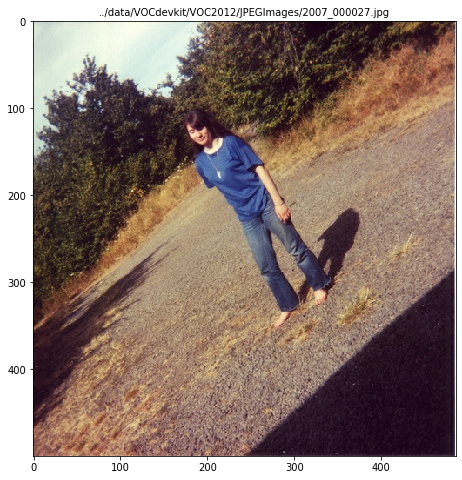

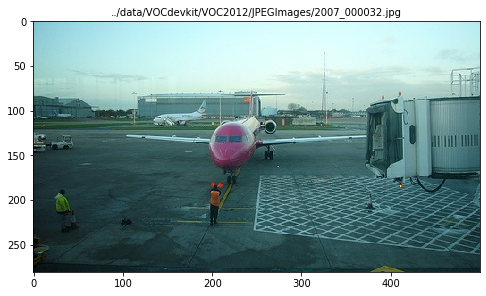

In [7]:
images = sorted(glob.glob(os.path.join(IMAGES_PATH, '*.jpg')))
annots = sorted(glob.glob(os.path.join(ANNOTATIONS_PATH, '*.xml')))
count = 0

for image, annot in (zip(images, annots)):
    count += 1
      
    error, image_string, image_data = process_image(image)
    image_info_list = parse_annot(annot)
    
    if count <= 2 and not error:
        print(image_info_list)
        
        f, (ax1) = plt.subplots(1, 1, figsize=(8,8))
        f.subplots_adjust(hspace = .2, wspace=.05)
    
        ax1.imshow(image_data)
        ax1.set_title('{}'.format(image), fontsize=10)
    else:
        break

## Write the TFRecord file

More example, please reference [tensorflow2-tutorials: tfrecords](https://github.com/kaka-lin/tensorflow2-tutorials/tree/master/load_and_preprocess_data/tfrecords)

### Creating a `tf.Example` message

In [8]:
def convert_voc_to_tf_example(image_string, image_info_list):
    """Convert Pascal VOC ground truth to TFExample protobuf."""
    for info in image_info_list:
        filename = info['filename']
        width = info['width']
        height = info['height']
        depth = info['depth']
        classes = info['class']
        xmin = info['xmin']
        ymin = info['ymin']
        xmax = info['xmax']
        ymax = info['ymax']
        
    if isinstance(image_string, type(tf.constant(0))):
        encoded_image = [image_string.numpy()]
    else:
        encoded_image = [image_string]
                
    base_name = [tf.compat.as_bytes(os.path.basename(filename))]
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'filename':tf.train.Feature(bytes_list=tf.train.BytesList(value=base_name)),
        'height':tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'width':tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'classes':tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
        'x_mins':tf.train.Feature(float_list=tf.train.FloatList(value=xmin)),
        'y_mins':tf.train.Feature(float_list=tf.train.FloatList(value=ymin)),
        'x_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=xmax)),
        'y_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=ymax)),
        'image_raw':tf.train.Feature(bytes_list=tf.train.BytesList(value=encoded_image))
    }))
    
    return example # example.SerializeToString()

In [9]:
example_proto = convert_voc_to_tf_example(image_string, image_info_list)
example_proto

features {
  feature {
    key: "classes"
    value {
      int64_list {
        value: 7
        value: 7
        value: 7
      }
    }
  }
  feature {
    key: "filename"
    value {
      bytes_list {
        value: "2007_000033.jpg"
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 366
      }
    }
  }
  feature {
    key: "image_raw"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\002\001\001\001\001\001\002\001\001\001\002\002\002\002\002\004\003\002\002\002\002\005\004\004\003\004\006\005\006\006\006\005\006\006\006\007\t\010\006\007\t\007\006\006\010\013\010\t\n\n\n\n\n\006\010\013\014\013\n\014\t\n\n\n\377\333\000C\001\002\002\002\002\002\002\005\003\003\005\n\007\006\007\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\377\300\000\021\010\001n\001\364\003\001\"\000\002\021\001\003\021\001\377\304\

### Writing the tf.Example to the TFRecord files

In [10]:
record_file = 'pascal.tfrecord'
with tf.io.TFRecordWriter(record_file) as writer:
    writer.write(example_proto.SerializeToString())

### Writing the all `tf.Example` message to the TFRecord files

In [11]:
!du -sh {record_file}

72K	pascal.tfrecord


In [12]:
def main():
    images = sorted(glob.glob(os.path.join(IMAGES_PATH, '*.jpg')))
    annots = sorted(glob.glob(os.path.join(ANNOTATIONS_PATH, '*.xml')))
    train_file = '../data/train_voc.tfrecord'
    counter = 0
    skipped = 0

    with tf.io.TFRecordWriter(train_file) as writer:
        for image, annot in (zip(images, annots)):
            # processes the image and parse the annotation
            error, image_string, image_data = process_image(image)
            image_info_list = parse_annot(annot)

            if not error:
                # convert voc to `tf.Example`
                example = convert_voc_to_tf_example(image_string, image_info_list)

                # write the `tf.example` message to the TFRecord files
                writer.write(example.SerializeToString())
                counter += 1
                print('{} : Processed {:d} of {:d} images.'.format(
                    datetime.now(), counter, len(images)))
            else:
                skipped += 1
                print('{} : Skipped {:d} of {:d} images.'.format(
                    datetime.now(), skipped, len(images)))

    print('{} : Wrote {} images to {}'.format(
            datetime.now(), counter, train_file))

In [13]:
main()

2020-02-12 17:18:25.527932 : Processed 1 of 17125 images.
2020-02-12 17:18:25.530419 : Processed 2 of 17125 images.
2020-02-12 17:18:25.532683 : Processed 3 of 17125 images.
2020-02-12 17:18:25.534729 : Processed 4 of 17125 images.
2020-02-12 17:18:25.537563 : Processed 5 of 17125 images.
2020-02-12 17:18:25.539893 : Processed 6 of 17125 images.
2020-02-12 17:18:25.542591 : Processed 7 of 17125 images.
2020-02-12 17:18:25.544999 : Processed 8 of 17125 images.
2020-02-12 17:18:25.547325 : Processed 9 of 17125 images.
2020-02-12 17:18:25.549350 : Processed 10 of 17125 images.
2020-02-12 17:18:25.551676 : Processed 11 of 17125 images.
2020-02-12 17:18:25.553758 : Processed 12 of 17125 images.
2020-02-12 17:18:25.556347 : Processed 13 of 17125 images.
2020-02-12 17:18:25.558388 : Processed 14 of 17125 images.
2020-02-12 17:18:25.560482 : Processed 15 of 17125 images.
2020-02-12 17:18:25.561831 : Processed 16 of 17125 images.
2020-02-12 17:18:25.563830 : Processed 17 of 17125 images.
2020-0

2020-02-12 17:18:25.932402 : Processed 179 of 17125 images.
2020-02-12 17:18:25.934480 : Processed 180 of 17125 images.
2020-02-12 17:18:25.936848 : Processed 181 of 17125 images.
2020-02-12 17:18:25.939257 : Processed 182 of 17125 images.
2020-02-12 17:18:25.941797 : Processed 183 of 17125 images.
2020-02-12 17:18:25.944052 : Processed 184 of 17125 images.
2020-02-12 17:18:25.946250 : Processed 185 of 17125 images.
2020-02-12 17:18:25.950041 : Processed 186 of 17125 images.
2020-02-12 17:18:25.953006 : Processed 187 of 17125 images.
2020-02-12 17:18:25.955013 : Processed 188 of 17125 images.
2020-02-12 17:18:25.957132 : Processed 189 of 17125 images.
2020-02-12 17:18:25.959570 : Processed 190 of 17125 images.
2020-02-12 17:18:25.962302 : Processed 191 of 17125 images.
2020-02-12 17:18:25.964576 : Processed 192 of 17125 images.
2020-02-12 17:18:25.966906 : Processed 193 of 17125 images.
2020-02-12 17:18:25.969369 : Processed 194 of 17125 images.
2020-02-12 17:18:25.971477 : Processed 1

2020-02-12 17:18:26.336081 : Processed 363 of 17125 images.
2020-02-12 17:18:26.338785 : Processed 364 of 17125 images.
2020-02-12 17:18:26.341085 : Processed 365 of 17125 images.
2020-02-12 17:18:26.343638 : Processed 366 of 17125 images.
2020-02-12 17:18:26.346807 : Processed 367 of 17125 images.
2020-02-12 17:18:26.349973 : Processed 368 of 17125 images.
2020-02-12 17:18:26.352732 : Processed 369 of 17125 images.
2020-02-12 17:18:26.354823 : Processed 370 of 17125 images.
2020-02-12 17:18:26.357413 : Processed 371 of 17125 images.
2020-02-12 17:18:26.359214 : Processed 372 of 17125 images.
2020-02-12 17:18:26.361227 : Processed 373 of 17125 images.
2020-02-12 17:18:26.363025 : Processed 374 of 17125 images.
2020-02-12 17:18:26.365503 : Processed 375 of 17125 images.
2020-02-12 17:18:26.367458 : Processed 376 of 17125 images.
2020-02-12 17:18:26.369823 : Processed 377 of 17125 images.
2020-02-12 17:18:26.371774 : Processed 378 of 17125 images.
2020-02-12 17:18:26.374141 : Processed 3

2020-02-12 17:18:26.739559 : Processed 544 of 17125 images.
2020-02-12 17:18:26.742160 : Processed 545 of 17125 images.
2020-02-12 17:18:26.744639 : Processed 546 of 17125 images.
2020-02-12 17:18:26.746259 : Processed 547 of 17125 images.
2020-02-12 17:18:26.749042 : Processed 548 of 17125 images.
2020-02-12 17:18:26.751217 : Processed 549 of 17125 images.
2020-02-12 17:18:26.753046 : Processed 550 of 17125 images.
2020-02-12 17:18:26.755170 : Processed 551 of 17125 images.
2020-02-12 17:18:26.757870 : Processed 552 of 17125 images.
2020-02-12 17:18:26.760747 : Processed 553 of 17125 images.
2020-02-12 17:18:26.762733 : Processed 554 of 17125 images.
2020-02-12 17:18:26.765021 : Processed 555 of 17125 images.
2020-02-12 17:18:26.767433 : Processed 556 of 17125 images.
2020-02-12 17:18:26.769558 : Processed 557 of 17125 images.
2020-02-12 17:18:26.771306 : Processed 558 of 17125 images.
2020-02-12 17:18:26.774917 : Processed 559 of 17125 images.
2020-02-12 17:18:26.776979 : Processed 5

2020-02-12 17:18:27.143023 : Processed 717 of 17125 images.
2020-02-12 17:18:27.145296 : Processed 718 of 17125 images.
2020-02-12 17:18:27.147884 : Processed 719 of 17125 images.
2020-02-12 17:18:27.150864 : Processed 720 of 17125 images.
2020-02-12 17:18:27.153030 : Processed 721 of 17125 images.
2020-02-12 17:18:27.155355 : Processed 722 of 17125 images.
2020-02-12 17:18:27.157616 : Processed 723 of 17125 images.
2020-02-12 17:18:27.159499 : Processed 724 of 17125 images.
2020-02-12 17:18:27.161327 : Processed 725 of 17125 images.
2020-02-12 17:18:27.163508 : Processed 726 of 17125 images.
2020-02-12 17:18:27.166120 : Processed 727 of 17125 images.
2020-02-12 17:18:27.168577 : Processed 728 of 17125 images.
2020-02-12 17:18:27.171201 : Processed 729 of 17125 images.
2020-02-12 17:18:27.174288 : Processed 730 of 17125 images.
2020-02-12 17:18:27.176378 : Processed 731 of 17125 images.
2020-02-12 17:18:27.178618 : Processed 732 of 17125 images.
2020-02-12 17:18:27.180321 : Processed 7

2020-02-12 17:18:27.550718 : Processed 877 of 17125 images.
2020-02-12 17:18:27.555983 : Processed 878 of 17125 images.
2020-02-12 17:18:27.558510 : Processed 879 of 17125 images.
2020-02-12 17:18:27.560765 : Processed 880 of 17125 images.
2020-02-12 17:18:27.562669 : Processed 881 of 17125 images.
2020-02-12 17:18:27.565295 : Processed 882 of 17125 images.
2020-02-12 17:18:27.568193 : Processed 883 of 17125 images.
2020-02-12 17:18:27.570496 : Processed 884 of 17125 images.
2020-02-12 17:18:27.573187 : Processed 885 of 17125 images.
2020-02-12 17:18:27.576840 : Processed 886 of 17125 images.
2020-02-12 17:18:27.578616 : Processed 887 of 17125 images.
2020-02-12 17:18:27.581250 : Processed 888 of 17125 images.
2020-02-12 17:18:27.583988 : Processed 889 of 17125 images.
2020-02-12 17:18:27.586505 : Processed 890 of 17125 images.
2020-02-12 17:18:27.589667 : Processed 891 of 17125 images.
2020-02-12 17:18:27.592106 : Processed 892 of 17125 images.
2020-02-12 17:18:27.595104 : Processed 8

2020-02-12 17:18:27.954524 : Processed 1028 of 17125 images.
2020-02-12 17:18:27.956747 : Processed 1029 of 17125 images.
2020-02-12 17:18:27.959786 : Processed 1030 of 17125 images.
2020-02-12 17:18:27.962679 : Processed 1031 of 17125 images.
2020-02-12 17:18:27.965085 : Processed 1032 of 17125 images.
2020-02-12 17:18:27.968061 : Processed 1033 of 17125 images.
2020-02-12 17:18:27.971601 : Processed 1034 of 17125 images.
2020-02-12 17:18:27.974650 : Processed 1035 of 17125 images.
2020-02-12 17:18:27.977314 : Processed 1036 of 17125 images.
2020-02-12 17:18:27.980978 : Processed 1037 of 17125 images.
2020-02-12 17:18:27.984285 : Processed 1038 of 17125 images.
2020-02-12 17:18:27.986864 : Processed 1039 of 17125 images.
2020-02-12 17:18:27.990367 : Processed 1040 of 17125 images.
2020-02-12 17:18:27.994245 : Processed 1041 of 17125 images.
2020-02-12 17:18:27.997316 : Processed 1042 of 17125 images.
2020-02-12 17:18:28.000036 : Processed 1043 of 17125 images.
2020-02-12 17:18:28.0037

2020-02-12 17:18:28.359346 : Processed 1179 of 17125 images.
2020-02-12 17:18:28.362088 : Processed 1180 of 17125 images.
2020-02-12 17:18:28.363547 : Processed 1181 of 17125 images.
2020-02-12 17:18:28.366573 : Processed 1182 of 17125 images.
2020-02-12 17:18:28.369726 : Processed 1183 of 17125 images.
2020-02-12 17:18:28.372704 : Processed 1184 of 17125 images.
2020-02-12 17:18:28.374803 : Processed 1185 of 17125 images.
2020-02-12 17:18:28.377410 : Processed 1186 of 17125 images.
2020-02-12 17:18:28.380072 : Processed 1187 of 17125 images.
2020-02-12 17:18:28.382650 : Processed 1188 of 17125 images.
2020-02-12 17:18:28.385598 : Processed 1189 of 17125 images.
2020-02-12 17:18:28.388238 : Processed 1190 of 17125 images.
2020-02-12 17:18:28.390997 : Processed 1191 of 17125 images.
2020-02-12 17:18:28.393731 : Processed 1192 of 17125 images.
2020-02-12 17:18:28.396537 : Processed 1193 of 17125 images.
2020-02-12 17:18:28.400304 : Processed 1194 of 17125 images.
2020-02-12 17:18:28.4034

2020-02-12 17:18:28.767796 : Processed 1331 of 17125 images.
2020-02-12 17:18:28.771146 : Processed 1332 of 17125 images.
2020-02-12 17:18:28.773889 : Processed 1333 of 17125 images.
2020-02-12 17:18:28.776452 : Processed 1334 of 17125 images.
2020-02-12 17:18:28.778910 : Processed 1335 of 17125 images.
2020-02-12 17:18:28.780891 : Processed 1336 of 17125 images.
2020-02-12 17:18:28.783372 : Processed 1337 of 17125 images.
2020-02-12 17:18:28.786177 : Processed 1338 of 17125 images.
2020-02-12 17:18:28.788974 : Processed 1339 of 17125 images.
2020-02-12 17:18:28.792309 : Processed 1340 of 17125 images.
2020-02-12 17:18:28.794093 : Processed 1341 of 17125 images.
2020-02-12 17:18:28.796387 : Processed 1342 of 17125 images.
2020-02-12 17:18:28.799453 : Processed 1343 of 17125 images.
2020-02-12 17:18:28.803632 : Processed 1344 of 17125 images.
2020-02-12 17:18:28.805733 : Processed 1345 of 17125 images.
2020-02-12 17:18:28.808138 : Processed 1346 of 17125 images.
2020-02-12 17:18:28.8108

2020-02-12 17:18:29.173504 : Processed 1483 of 17125 images.
2020-02-12 17:18:29.176581 : Processed 1484 of 17125 images.
2020-02-12 17:18:29.179386 : Processed 1485 of 17125 images.
2020-02-12 17:18:29.182340 : Processed 1486 of 17125 images.
2020-02-12 17:18:29.185546 : Processed 1487 of 17125 images.
2020-02-12 17:18:29.188047 : Processed 1488 of 17125 images.
2020-02-12 17:18:29.191142 : Processed 1489 of 17125 images.
2020-02-12 17:18:29.193374 : Processed 1490 of 17125 images.
2020-02-12 17:18:29.196720 : Processed 1491 of 17125 images.
2020-02-12 17:18:29.199747 : Processed 1492 of 17125 images.
2020-02-12 17:18:29.202708 : Processed 1493 of 17125 images.
2020-02-12 17:18:29.205905 : Processed 1494 of 17125 images.
2020-02-12 17:18:29.208607 : Processed 1495 of 17125 images.
2020-02-12 17:18:29.211039 : Processed 1496 of 17125 images.
2020-02-12 17:18:29.214973 : Processed 1497 of 17125 images.
2020-02-12 17:18:29.217629 : Processed 1498 of 17125 images.
2020-02-12 17:18:29.2212

2020-02-12 17:18:29.582224 : Processed 1624 of 17125 images.
2020-02-12 17:18:29.586970 : Processed 1625 of 17125 images.
2020-02-12 17:18:29.590871 : Processed 1626 of 17125 images.
2020-02-12 17:18:29.593171 : Processed 1627 of 17125 images.
2020-02-12 17:18:29.596164 : Processed 1628 of 17125 images.
2020-02-12 17:18:29.598874 : Processed 1629 of 17125 images.
2020-02-12 17:18:29.601259 : Processed 1630 of 17125 images.
2020-02-12 17:18:29.603970 : Processed 1631 of 17125 images.
2020-02-12 17:18:29.606247 : Processed 1632 of 17125 images.
2020-02-12 17:18:29.608909 : Processed 1633 of 17125 images.
2020-02-12 17:18:29.611281 : Processed 1634 of 17125 images.
2020-02-12 17:18:29.613119 : Processed 1635 of 17125 images.
2020-02-12 17:18:29.616655 : Processed 1636 of 17125 images.
2020-02-12 17:18:29.618684 : Processed 1637 of 17125 images.
2020-02-12 17:18:29.620783 : Processed 1638 of 17125 images.
2020-02-12 17:18:29.623317 : Processed 1639 of 17125 images.
2020-02-12 17:18:29.6251

2020-02-12 17:18:29.986940 : Processed 1783 of 17125 images.
2020-02-12 17:18:29.989061 : Processed 1784 of 17125 images.
2020-02-12 17:18:29.991839 : Processed 1785 of 17125 images.
2020-02-12 17:18:29.995475 : Processed 1786 of 17125 images.
2020-02-12 17:18:29.998048 : Processed 1787 of 17125 images.
2020-02-12 17:18:30.001973 : Processed 1788 of 17125 images.
2020-02-12 17:18:30.004605 : Processed 1789 of 17125 images.
2020-02-12 17:18:30.007787 : Processed 1790 of 17125 images.
2020-02-12 17:18:30.010766 : Processed 1791 of 17125 images.
2020-02-12 17:18:30.013424 : Processed 1792 of 17125 images.
2020-02-12 17:18:30.016625 : Processed 1793 of 17125 images.
2020-02-12 17:18:30.019924 : Processed 1794 of 17125 images.
2020-02-12 17:18:30.022075 : Processed 1795 of 17125 images.
2020-02-12 17:18:30.025159 : Processed 1796 of 17125 images.
2020-02-12 17:18:30.028336 : Processed 1797 of 17125 images.
2020-02-12 17:18:30.030455 : Processed 1798 of 17125 images.
2020-02-12 17:18:30.0328

2020-02-12 17:18:30.390996 : Processed 1935 of 17125 images.
2020-02-12 17:18:30.393499 : Processed 1936 of 17125 images.
2020-02-12 17:18:30.396099 : Processed 1937 of 17125 images.
2020-02-12 17:18:30.398474 : Processed 1938 of 17125 images.
2020-02-12 17:18:30.400454 : Processed 1939 of 17125 images.
2020-02-12 17:18:30.402444 : Processed 1940 of 17125 images.
2020-02-12 17:18:30.404887 : Processed 1941 of 17125 images.
2020-02-12 17:18:30.406963 : Processed 1942 of 17125 images.
2020-02-12 17:18:30.410437 : Processed 1943 of 17125 images.
2020-02-12 17:18:30.413722 : Processed 1944 of 17125 images.
2020-02-12 17:18:30.417884 : Processed 1945 of 17125 images.
2020-02-12 17:18:30.421097 : Processed 1946 of 17125 images.
2020-02-12 17:18:30.424457 : Processed 1947 of 17125 images.
2020-02-12 17:18:30.426820 : Processed 1948 of 17125 images.
2020-02-12 17:18:30.428847 : Processed 1949 of 17125 images.
2020-02-12 17:18:30.431567 : Processed 1950 of 17125 images.
2020-02-12 17:18:30.4342

2020-02-12 17:18:30.794890 : Processed 2093 of 17125 images.
2020-02-12 17:18:30.798343 : Processed 2094 of 17125 images.
2020-02-12 17:18:30.800470 : Processed 2095 of 17125 images.
2020-02-12 17:18:30.803642 : Processed 2096 of 17125 images.
2020-02-12 17:18:30.806243 : Processed 2097 of 17125 images.
2020-02-12 17:18:30.808451 : Processed 2098 of 17125 images.
2020-02-12 17:18:30.811174 : Processed 2099 of 17125 images.
2020-02-12 17:18:30.812619 : Processed 2100 of 17125 images.
2020-02-12 17:18:30.814312 : Processed 2101 of 17125 images.
2020-02-12 17:18:30.816175 : Processed 2102 of 17125 images.
2020-02-12 17:18:30.819495 : Processed 2103 of 17125 images.
2020-02-12 17:18:30.821588 : Processed 2104 of 17125 images.
2020-02-12 17:18:30.822780 : Processed 2105 of 17125 images.
2020-02-12 17:18:30.824341 : Processed 2106 of 17125 images.
2020-02-12 17:18:30.825844 : Processed 2107 of 17125 images.
2020-02-12 17:18:30.828967 : Processed 2108 of 17125 images.
2020-02-12 17:18:30.8323

2020-02-12 17:18:31.198040 : Processed 2239 of 17125 images.
2020-02-12 17:18:31.201261 : Processed 2240 of 17125 images.
2020-02-12 17:18:31.204125 : Processed 2241 of 17125 images.
2020-02-12 17:18:31.206341 : Processed 2242 of 17125 images.
2020-02-12 17:18:31.208767 : Processed 2243 of 17125 images.
2020-02-12 17:18:31.210934 : Processed 2244 of 17125 images.
2020-02-12 17:18:31.213681 : Processed 2245 of 17125 images.
2020-02-12 17:18:31.217044 : Processed 2246 of 17125 images.
2020-02-12 17:18:31.220287 : Processed 2247 of 17125 images.
2020-02-12 17:18:31.223216 : Processed 2248 of 17125 images.
2020-02-12 17:18:31.225136 : Processed 2249 of 17125 images.
2020-02-12 17:18:31.227785 : Processed 2250 of 17125 images.
2020-02-12 17:18:31.229668 : Processed 2251 of 17125 images.
2020-02-12 17:18:31.232506 : Processed 2252 of 17125 images.
2020-02-12 17:18:31.233840 : Processed 2253 of 17125 images.
2020-02-12 17:18:31.236493 : Processed 2254 of 17125 images.
2020-02-12 17:18:31.2389

2020-02-12 17:18:31.601757 : Processed 2386 of 17125 images.
2020-02-12 17:18:31.604615 : Processed 2387 of 17125 images.
2020-02-12 17:18:31.607574 : Processed 2388 of 17125 images.
2020-02-12 17:18:31.610273 : Processed 2389 of 17125 images.
2020-02-12 17:18:31.613864 : Processed 2390 of 17125 images.
2020-02-12 17:18:31.616679 : Processed 2391 of 17125 images.
2020-02-12 17:18:31.619258 : Processed 2392 of 17125 images.
2020-02-12 17:18:31.621690 : Processed 2393 of 17125 images.
2020-02-12 17:18:31.624326 : Processed 2394 of 17125 images.
2020-02-12 17:18:31.626614 : Processed 2395 of 17125 images.
2020-02-12 17:18:31.629866 : Processed 2396 of 17125 images.
2020-02-12 17:18:31.632777 : Processed 2397 of 17125 images.
2020-02-12 17:18:31.636033 : Processed 2398 of 17125 images.
2020-02-12 17:18:31.639671 : Processed 2399 of 17125 images.
2020-02-12 17:18:31.643325 : Processed 2400 of 17125 images.
2020-02-12 17:18:31.644558 : Processed 2401 of 17125 images.
2020-02-12 17:18:31.6468

2020-02-12 17:18:32.007329 : Processed 2544 of 17125 images.
2020-02-12 17:18:32.011438 : Processed 2545 of 17125 images.
2020-02-12 17:18:32.014867 : Processed 2546 of 17125 images.
2020-02-12 17:18:32.018437 : Processed 2547 of 17125 images.
2020-02-12 17:18:32.021307 : Processed 2548 of 17125 images.
2020-02-12 17:18:32.023851 : Processed 2549 of 17125 images.
2020-02-12 17:18:32.026495 : Processed 2550 of 17125 images.
2020-02-12 17:18:32.029946 : Processed 2551 of 17125 images.
2020-02-12 17:18:32.033721 : Processed 2552 of 17125 images.
2020-02-12 17:18:32.036812 : Processed 2553 of 17125 images.
2020-02-12 17:18:32.039075 : Processed 2554 of 17125 images.
2020-02-12 17:18:32.040814 : Processed 2555 of 17125 images.
2020-02-12 17:18:32.043947 : Processed 2556 of 17125 images.
2020-02-12 17:18:32.046860 : Processed 2557 of 17125 images.
2020-02-12 17:18:32.049769 : Processed 2558 of 17125 images.
2020-02-12 17:18:32.051765 : Processed 2559 of 17125 images.
2020-02-12 17:18:32.0541

2020-02-12 17:18:32.419641 : Processed 2696 of 17125 images.
2020-02-12 17:18:32.424033 : Processed 2697 of 17125 images.
2020-02-12 17:18:32.438506 : Processed 2698 of 17125 images.
2020-02-12 17:18:32.442195 : Processed 2699 of 17125 images.
2020-02-12 17:18:32.446646 : Processed 2700 of 17125 images.
2020-02-12 17:18:32.450602 : Processed 2701 of 17125 images.
2020-02-12 17:18:32.453880 : Processed 2702 of 17125 images.
2020-02-12 17:18:32.457577 : Processed 2703 of 17125 images.
2020-02-12 17:18:32.460087 : Processed 2704 of 17125 images.
2020-02-12 17:18:32.462592 : Processed 2705 of 17125 images.
2020-02-12 17:18:32.465235 : Processed 2706 of 17125 images.
2020-02-12 17:18:32.468114 : Processed 2707 of 17125 images.
2020-02-12 17:18:32.471874 : Processed 2708 of 17125 images.
2020-02-12 17:18:32.475376 : Processed 2709 of 17125 images.
2020-02-12 17:18:32.480110 : Processed 2710 of 17125 images.
2020-02-12 17:18:32.482969 : Processed 2711 of 17125 images.
2020-02-12 17:18:32.4867

2020-02-12 17:18:32.830049 : Processed 2834 of 17125 images.
2020-02-12 17:18:32.833131 : Processed 2835 of 17125 images.
2020-02-12 17:18:32.836318 : Processed 2836 of 17125 images.
2020-02-12 17:18:32.838497 : Processed 2837 of 17125 images.
2020-02-12 17:18:32.841344 : Processed 2838 of 17125 images.
2020-02-12 17:18:32.843532 : Processed 2839 of 17125 images.
2020-02-12 17:18:32.846378 : Processed 2840 of 17125 images.
2020-02-12 17:18:32.848055 : Processed 2841 of 17125 images.
2020-02-12 17:18:32.850437 : Processed 2842 of 17125 images.
2020-02-12 17:18:32.852193 : Processed 2843 of 17125 images.
2020-02-12 17:18:32.855019 : Processed 2844 of 17125 images.
2020-02-12 17:18:32.857832 : Processed 2845 of 17125 images.
2020-02-12 17:18:32.860243 : Processed 2846 of 17125 images.
2020-02-12 17:18:32.861979 : Processed 2847 of 17125 images.
2020-02-12 17:18:32.864018 : Processed 2848 of 17125 images.
2020-02-12 17:18:32.866325 : Processed 2849 of 17125 images.
2020-02-12 17:18:32.8690

2020-02-12 17:18:33.235189 : Processed 2995 of 17125 images.
2020-02-12 17:18:33.236937 : Processed 2996 of 17125 images.
2020-02-12 17:18:33.240919 : Processed 2997 of 17125 images.
2020-02-12 17:18:33.242850 : Processed 2998 of 17125 images.
2020-02-12 17:18:33.246528 : Processed 2999 of 17125 images.
2020-02-12 17:18:33.248112 : Processed 3000 of 17125 images.
2020-02-12 17:18:33.251828 : Processed 3001 of 17125 images.
2020-02-12 17:18:33.255260 : Processed 3002 of 17125 images.
2020-02-12 17:18:33.258075 : Processed 3003 of 17125 images.
2020-02-12 17:18:33.260993 : Processed 3004 of 17125 images.
2020-02-12 17:18:33.262768 : Processed 3005 of 17125 images.
2020-02-12 17:18:33.265448 : Processed 3006 of 17125 images.
2020-02-12 17:18:33.267923 : Processed 3007 of 17125 images.
2020-02-12 17:18:33.271474 : Processed 3008 of 17125 images.
2020-02-12 17:18:33.274880 : Processed 3009 of 17125 images.
2020-02-12 17:18:33.277805 : Processed 3010 of 17125 images.
2020-02-12 17:18:33.2811

2020-02-12 17:18:33.639962 : Processed 3143 of 17125 images.
2020-02-12 17:18:33.644014 : Processed 3144 of 17125 images.
2020-02-12 17:18:33.647979 : Processed 3145 of 17125 images.
2020-02-12 17:18:33.651188 : Processed 3146 of 17125 images.
2020-02-12 17:18:33.653617 : Processed 3147 of 17125 images.
2020-02-12 17:18:33.656206 : Processed 3148 of 17125 images.
2020-02-12 17:18:33.660125 : Processed 3149 of 17125 images.
2020-02-12 17:18:33.664152 : Processed 3150 of 17125 images.
2020-02-12 17:18:33.667505 : Processed 3151 of 17125 images.
2020-02-12 17:18:33.672434 : Processed 3152 of 17125 images.
2020-02-12 17:18:33.675180 : Processed 3153 of 17125 images.
2020-02-12 17:18:33.678482 : Processed 3154 of 17125 images.
2020-02-12 17:18:33.681934 : Processed 3155 of 17125 images.
2020-02-12 17:18:33.684950 : Processed 3156 of 17125 images.
2020-02-12 17:18:33.688663 : Processed 3157 of 17125 images.
2020-02-12 17:18:33.692252 : Processed 3158 of 17125 images.
2020-02-12 17:18:33.6949

2020-02-12 17:18:34.051720 : Processed 3285 of 17125 images.
2020-02-12 17:18:34.055313 : Processed 3286 of 17125 images.
2020-02-12 17:18:34.059136 : Processed 3287 of 17125 images.
2020-02-12 17:18:34.062122 : Processed 3288 of 17125 images.
2020-02-12 17:18:34.063730 : Processed 3289 of 17125 images.
2020-02-12 17:18:34.066074 : Processed 3290 of 17125 images.
2020-02-12 17:18:34.069835 : Processed 3291 of 17125 images.
2020-02-12 17:18:34.072468 : Processed 3292 of 17125 images.
2020-02-12 17:18:34.074868 : Processed 3293 of 17125 images.
2020-02-12 17:18:34.077780 : Processed 3294 of 17125 images.
2020-02-12 17:18:34.080740 : Processed 3295 of 17125 images.
2020-02-12 17:18:34.083469 : Processed 3296 of 17125 images.
2020-02-12 17:18:34.085398 : Processed 3297 of 17125 images.
2020-02-12 17:18:34.087792 : Processed 3298 of 17125 images.
2020-02-12 17:18:34.090055 : Processed 3299 of 17125 images.
2020-02-12 17:18:34.092329 : Processed 3300 of 17125 images.
2020-02-12 17:18:34.0962

2020-02-12 17:18:34.455297 : Processed 3433 of 17125 images.
2020-02-12 17:18:34.459903 : Processed 3434 of 17125 images.
2020-02-12 17:18:34.463359 : Processed 3435 of 17125 images.
2020-02-12 17:18:34.466445 : Processed 3436 of 17125 images.
2020-02-12 17:18:34.468135 : Processed 3437 of 17125 images.
2020-02-12 17:18:34.471050 : Processed 3438 of 17125 images.
2020-02-12 17:18:34.473996 : Processed 3439 of 17125 images.
2020-02-12 17:18:34.476547 : Processed 3440 of 17125 images.
2020-02-12 17:18:34.479147 : Processed 3441 of 17125 images.
2020-02-12 17:18:34.481582 : Processed 3442 of 17125 images.
2020-02-12 17:18:34.484573 : Processed 3443 of 17125 images.
2020-02-12 17:18:34.487773 : Processed 3444 of 17125 images.
2020-02-12 17:18:34.489963 : Processed 3445 of 17125 images.
2020-02-12 17:18:34.493407 : Processed 3446 of 17125 images.
2020-02-12 17:18:34.496306 : Processed 3447 of 17125 images.
2020-02-12 17:18:34.500508 : Processed 3448 of 17125 images.
2020-02-12 17:18:34.5028

2020-02-12 17:18:34.861093 : Processed 3589 of 17125 images.
2020-02-12 17:18:34.864482 : Processed 3590 of 17125 images.
2020-02-12 17:18:34.868090 : Processed 3591 of 17125 images.
2020-02-12 17:18:34.870447 : Processed 3592 of 17125 images.
2020-02-12 17:18:34.872349 : Processed 3593 of 17125 images.
2020-02-12 17:18:34.874963 : Processed 3594 of 17125 images.
2020-02-12 17:18:34.877701 : Processed 3595 of 17125 images.
2020-02-12 17:18:34.879557 : Processed 3596 of 17125 images.
2020-02-12 17:18:34.881085 : Processed 3597 of 17125 images.
2020-02-12 17:18:34.883301 : Processed 3598 of 17125 images.
2020-02-12 17:18:34.886365 : Processed 3599 of 17125 images.
2020-02-12 17:18:34.890461 : Processed 3600 of 17125 images.
2020-02-12 17:18:34.893178 : Processed 3601 of 17125 images.
2020-02-12 17:18:34.896499 : Processed 3602 of 17125 images.
2020-02-12 17:18:34.898824 : Processed 3603 of 17125 images.
2020-02-12 17:18:34.903196 : Processed 3604 of 17125 images.
2020-02-12 17:18:34.9050

2020-02-12 17:18:35.264825 : Processed 3736 of 17125 images.
2020-02-12 17:18:35.268331 : Processed 3737 of 17125 images.
2020-02-12 17:18:35.270674 : Processed 3738 of 17125 images.
2020-02-12 17:18:35.273133 : Processed 3739 of 17125 images.
2020-02-12 17:18:35.275969 : Processed 3740 of 17125 images.
2020-02-12 17:18:35.278491 : Processed 3741 of 17125 images.
2020-02-12 17:18:35.280852 : Processed 3742 of 17125 images.
2020-02-12 17:18:35.284308 : Processed 3743 of 17125 images.
2020-02-12 17:18:35.286785 : Processed 3744 of 17125 images.
2020-02-12 17:18:35.289257 : Processed 3745 of 17125 images.
2020-02-12 17:18:35.291044 : Processed 3746 of 17125 images.
2020-02-12 17:18:35.292981 : Processed 3747 of 17125 images.
2020-02-12 17:18:35.294952 : Processed 3748 of 17125 images.
2020-02-12 17:18:35.297499 : Processed 3749 of 17125 images.
2020-02-12 17:18:35.300571 : Processed 3750 of 17125 images.
2020-02-12 17:18:35.304170 : Processed 3751 of 17125 images.
2020-02-12 17:18:35.3071

2020-02-12 17:18:35.669839 : Processed 3888 of 17125 images.
2020-02-12 17:18:35.672908 : Processed 3889 of 17125 images.
2020-02-12 17:18:35.675954 : Processed 3890 of 17125 images.
2020-02-12 17:18:35.677831 : Processed 3891 of 17125 images.
2020-02-12 17:18:35.680115 : Processed 3892 of 17125 images.
2020-02-12 17:18:35.682947 : Processed 3893 of 17125 images.
2020-02-12 17:18:35.684717 : Processed 3894 of 17125 images.
2020-02-12 17:18:35.687066 : Processed 3895 of 17125 images.
2020-02-12 17:18:35.689867 : Processed 3896 of 17125 images.
2020-02-12 17:18:35.693691 : Processed 3897 of 17125 images.
2020-02-12 17:18:35.696547 : Processed 3898 of 17125 images.
2020-02-12 17:18:35.699459 : Processed 3899 of 17125 images.
2020-02-12 17:18:35.702673 : Processed 3900 of 17125 images.
2020-02-12 17:18:35.706156 : Processed 3901 of 17125 images.
2020-02-12 17:18:35.709458 : Processed 3902 of 17125 images.
2020-02-12 17:18:35.712853 : Processed 3903 of 17125 images.
2020-02-12 17:18:35.7168

2020-02-12 17:18:36.075892 : Processed 4042 of 17125 images.
2020-02-12 17:18:36.078225 : Processed 4043 of 17125 images.
2020-02-12 17:18:36.081597 : Processed 4044 of 17125 images.
2020-02-12 17:18:36.084614 : Processed 4045 of 17125 images.
2020-02-12 17:18:36.087241 : Processed 4046 of 17125 images.
2020-02-12 17:18:36.089701 : Processed 4047 of 17125 images.
2020-02-12 17:18:36.093056 : Processed 4048 of 17125 images.
2020-02-12 17:18:36.095624 : Processed 4049 of 17125 images.
2020-02-12 17:18:36.100055 : Processed 4050 of 17125 images.
2020-02-12 17:18:36.104750 : Processed 4051 of 17125 images.
2020-02-12 17:18:36.108066 : Processed 4052 of 17125 images.
2020-02-12 17:18:36.111010 : Processed 4053 of 17125 images.
2020-02-12 17:18:36.114080 : Processed 4054 of 17125 images.
2020-02-12 17:18:36.115826 : Processed 4055 of 17125 images.
2020-02-12 17:18:36.117929 : Processed 4056 of 17125 images.
2020-02-12 17:18:36.120961 : Processed 4057 of 17125 images.
2020-02-12 17:18:36.1228

2020-02-12 17:18:36.481222 : Processed 4194 of 17125 images.
2020-02-12 17:18:36.485082 : Processed 4195 of 17125 images.
2020-02-12 17:18:36.488695 : Processed 4196 of 17125 images.
2020-02-12 17:18:36.490047 : Processed 4197 of 17125 images.
2020-02-12 17:18:36.493143 : Processed 4198 of 17125 images.
2020-02-12 17:18:36.495186 : Processed 4199 of 17125 images.
2020-02-12 17:18:36.498125 : Processed 4200 of 17125 images.
2020-02-12 17:18:36.500759 : Processed 4201 of 17125 images.
2020-02-12 17:18:36.502565 : Processed 4202 of 17125 images.
2020-02-12 17:18:36.504864 : Processed 4203 of 17125 images.
2020-02-12 17:18:36.508328 : Processed 4204 of 17125 images.
2020-02-12 17:18:36.511837 : Processed 4205 of 17125 images.
2020-02-12 17:18:36.515055 : Processed 4206 of 17125 images.
2020-02-12 17:18:36.518917 : Processed 4207 of 17125 images.
2020-02-12 17:18:36.521921 : Processed 4208 of 17125 images.
2020-02-12 17:18:36.524058 : Processed 4209 of 17125 images.
2020-02-12 17:18:36.5267

2020-02-12 17:18:36.884320 : Processed 4345 of 17125 images.
2020-02-12 17:18:36.888241 : Processed 4346 of 17125 images.
2020-02-12 17:18:36.891762 : Processed 4347 of 17125 images.
2020-02-12 17:18:36.894395 : Processed 4348 of 17125 images.
2020-02-12 17:18:36.898320 : Processed 4349 of 17125 images.
2020-02-12 17:18:36.901831 : Processed 4350 of 17125 images.
2020-02-12 17:18:36.904903 : Processed 4351 of 17125 images.
2020-02-12 17:18:36.908084 : Processed 4352 of 17125 images.
2020-02-12 17:18:36.910721 : Processed 4353 of 17125 images.
2020-02-12 17:18:36.912859 : Processed 4354 of 17125 images.
2020-02-12 17:18:36.916030 : Processed 4355 of 17125 images.
2020-02-12 17:18:36.919155 : Processed 4356 of 17125 images.
2020-02-12 17:18:36.923192 : Processed 4357 of 17125 images.
2020-02-12 17:18:36.926930 : Processed 4358 of 17125 images.
2020-02-12 17:18:36.930743 : Processed 4359 of 17125 images.
2020-02-12 17:18:36.932956 : Processed 4360 of 17125 images.
2020-02-12 17:18:36.9371

2020-02-12 17:18:37.492568 : Processed 4495 of 17125 images.
2020-02-12 17:18:37.495415 : Processed 4496 of 17125 images.
2020-02-12 17:18:37.499599 : Processed 4497 of 17125 images.
2020-02-12 17:18:37.519737 : Processed 4498 of 17125 images.
2020-02-12 17:18:37.529081 : Processed 4499 of 17125 images.
2020-02-12 17:18:37.539842 : Processed 4500 of 17125 images.
2020-02-12 17:18:37.549003 : Processed 4501 of 17125 images.
2020-02-12 17:18:37.554478 : Processed 4502 of 17125 images.
2020-02-12 17:18:37.558796 : Processed 4503 of 17125 images.
2020-02-12 17:18:37.562045 : Processed 4504 of 17125 images.
2020-02-12 17:18:37.564472 : Processed 4505 of 17125 images.
2020-02-12 17:18:37.567151 : Processed 4506 of 17125 images.
2020-02-12 17:18:37.582721 : Processed 4507 of 17125 images.
2020-02-12 17:18:37.587180 : Processed 4508 of 17125 images.
2020-02-12 17:18:37.591717 : Processed 4509 of 17125 images.
2020-02-12 17:18:37.596203 : Processed 4510 of 17125 images.
2020-02-12 17:18:37.5995

2020-02-12 17:18:38.319387 : Processed 4649 of 17125 images.
2020-02-12 17:18:38.324860 : Processed 4650 of 17125 images.
2020-02-12 17:18:38.330209 : Processed 4651 of 17125 images.
2020-02-12 17:18:38.334147 : Processed 4652 of 17125 images.
2020-02-12 17:18:38.337334 : Processed 4653 of 17125 images.
2020-02-12 17:18:38.339878 : Processed 4654 of 17125 images.
2020-02-12 17:18:38.343876 : Processed 4655 of 17125 images.
2020-02-12 17:18:38.348092 : Processed 4656 of 17125 images.
2020-02-12 17:18:38.352912 : Processed 4657 of 17125 images.
2020-02-12 17:18:38.357218 : Processed 4658 of 17125 images.
2020-02-12 17:18:38.361784 : Processed 4659 of 17125 images.
2020-02-12 17:18:38.364903 : Processed 4660 of 17125 images.
2020-02-12 17:18:38.368676 : Processed 4661 of 17125 images.
2020-02-12 17:18:38.371352 : Processed 4662 of 17125 images.
2020-02-12 17:18:38.374331 : Processed 4663 of 17125 images.
2020-02-12 17:18:38.378680 : Processed 4664 of 17125 images.
2020-02-12 17:18:38.3979

2020-02-12 17:18:38.928043 : Processed 4785 of 17125 images.
2020-02-12 17:18:38.932290 : Processed 4786 of 17125 images.
2020-02-12 17:18:38.936982 : Processed 4787 of 17125 images.
2020-02-12 17:18:38.940880 : Processed 4788 of 17125 images.
2020-02-12 17:18:38.945093 : Processed 4789 of 17125 images.
2020-02-12 17:18:38.954413 : Processed 4790 of 17125 images.
2020-02-12 17:18:38.964112 : Processed 4791 of 17125 images.
2020-02-12 17:18:38.969490 : Processed 4792 of 17125 images.
2020-02-12 17:18:38.978016 : Processed 4793 of 17125 images.
2020-02-12 17:18:38.982668 : Processed 4794 of 17125 images.
2020-02-12 17:18:38.986637 : Processed 4795 of 17125 images.
2020-02-12 17:18:38.992009 : Processed 4796 of 17125 images.
2020-02-12 17:18:38.997311 : Processed 4797 of 17125 images.
2020-02-12 17:18:39.001612 : Processed 4798 of 17125 images.
2020-02-12 17:18:39.003932 : Processed 4799 of 17125 images.
2020-02-12 17:18:39.007480 : Processed 4800 of 17125 images.
2020-02-12 17:18:39.0106

2020-02-12 17:18:39.539234 : Processed 4929 of 17125 images.
2020-02-12 17:18:39.542500 : Processed 4930 of 17125 images.
2020-02-12 17:18:39.545800 : Processed 4931 of 17125 images.
2020-02-12 17:18:39.550777 : Processed 4932 of 17125 images.
2020-02-12 17:18:39.554919 : Processed 4933 of 17125 images.
2020-02-12 17:18:39.560537 : Processed 4934 of 17125 images.
2020-02-12 17:18:39.565343 : Processed 4935 of 17125 images.
2020-02-12 17:18:39.568675 : Processed 4936 of 17125 images.
2020-02-12 17:18:39.584986 : Processed 4937 of 17125 images.
2020-02-12 17:18:39.588686 : Processed 4938 of 17125 images.
2020-02-12 17:18:39.594253 : Processed 4939 of 17125 images.
2020-02-12 17:18:39.608460 : Processed 4940 of 17125 images.
2020-02-12 17:18:39.625549 : Processed 4941 of 17125 images.
2020-02-12 17:18:39.631371 : Processed 4942 of 17125 images.
2020-02-12 17:18:39.635215 : Processed 4943 of 17125 images.
2020-02-12 17:18:39.639356 : Processed 4944 of 17125 images.
2020-02-12 17:18:39.6427

2020-02-12 17:18:40.364248 : Processed 5079 of 17125 images.
2020-02-12 17:18:40.376396 : Processed 5080 of 17125 images.
2020-02-12 17:18:40.394937 : Processed 5081 of 17125 images.
2020-02-12 17:18:40.400349 : Processed 5082 of 17125 images.
2020-02-12 17:18:40.406345 : Processed 5083 of 17125 images.
2020-02-12 17:18:40.410541 : Processed 5084 of 17125 images.
2020-02-12 17:18:40.414501 : Processed 5085 of 17125 images.
2020-02-12 17:18:40.418444 : Processed 5086 of 17125 images.
2020-02-12 17:18:40.425056 : Processed 5087 of 17125 images.
2020-02-12 17:18:40.429895 : Processed 5088 of 17125 images.
2020-02-12 17:18:40.451980 : Processed 5089 of 17125 images.
2020-02-12 17:18:40.459776 : Processed 5090 of 17125 images.
2020-02-12 17:18:40.465613 : Processed 5091 of 17125 images.
2020-02-12 17:18:40.469085 : Processed 5092 of 17125 images.
2020-02-12 17:18:40.473537 : Processed 5093 of 17125 images.
2020-02-12 17:18:40.476245 : Processed 5094 of 17125 images.
2020-02-12 17:18:40.4816

2020-02-12 17:18:40.972068 : Processed 5217 of 17125 images.
2020-02-12 17:18:40.976110 : Processed 5218 of 17125 images.
2020-02-12 17:18:40.980484 : Processed 5219 of 17125 images.
2020-02-12 17:18:40.984752 : Processed 5220 of 17125 images.
2020-02-12 17:18:40.988386 : Processed 5221 of 17125 images.
2020-02-12 17:18:40.991550 : Processed 5222 of 17125 images.
2020-02-12 17:18:40.994194 : Processed 5223 of 17125 images.
2020-02-12 17:18:40.998008 : Processed 5224 of 17125 images.
2020-02-12 17:18:41.001758 : Processed 5225 of 17125 images.
2020-02-12 17:18:41.004340 : Processed 5226 of 17125 images.
2020-02-12 17:18:41.008209 : Processed 5227 of 17125 images.
2020-02-12 17:18:41.011186 : Processed 5228 of 17125 images.
2020-02-12 17:18:41.014762 : Processed 5229 of 17125 images.
2020-02-12 17:18:41.017748 : Processed 5230 of 17125 images.
2020-02-12 17:18:41.020358 : Processed 5231 of 17125 images.
2020-02-12 17:18:41.022437 : Processed 5232 of 17125 images.
2020-02-12 17:18:41.0255

2020-02-12 17:18:41.581932 : Processed 5361 of 17125 images.
2020-02-12 17:18:41.585680 : Processed 5362 of 17125 images.
2020-02-12 17:18:41.588667 : Processed 5363 of 17125 images.
2020-02-12 17:18:41.592447 : Processed 5364 of 17125 images.
2020-02-12 17:18:41.596347 : Processed 5365 of 17125 images.
2020-02-12 17:18:41.600194 : Processed 5366 of 17125 images.
2020-02-12 17:18:41.610503 : Processed 5367 of 17125 images.
2020-02-12 17:18:41.613409 : Processed 5368 of 17125 images.
2020-02-12 17:18:41.619009 : Processed 5369 of 17125 images.
2020-02-12 17:18:41.622163 : Processed 5370 of 17125 images.
2020-02-12 17:18:41.625359 : Processed 5371 of 17125 images.
2020-02-12 17:18:41.628240 : Processed 5372 of 17125 images.
2020-02-12 17:18:41.631155 : Processed 5373 of 17125 images.
2020-02-12 17:18:41.634964 : Processed 5374 of 17125 images.
2020-02-12 17:18:41.639080 : Processed 5375 of 17125 images.
2020-02-12 17:18:41.642326 : Processed 5376 of 17125 images.
2020-02-12 17:18:41.6472

2020-02-12 17:18:42.198464 : Processed 5503 of 17125 images.
2020-02-12 17:18:42.204569 : Processed 5504 of 17125 images.
2020-02-12 17:18:42.208183 : Processed 5505 of 17125 images.
2020-02-12 17:18:42.211786 : Processed 5506 of 17125 images.
2020-02-12 17:18:42.215850 : Processed 5507 of 17125 images.
2020-02-12 17:18:42.219068 : Processed 5508 of 17125 images.
2020-02-12 17:18:42.221690 : Processed 5509 of 17125 images.
2020-02-12 17:18:42.224660 : Processed 5510 of 17125 images.
2020-02-12 17:18:42.227826 : Processed 5511 of 17125 images.
2020-02-12 17:18:42.231941 : Processed 5512 of 17125 images.
2020-02-12 17:18:42.235296 : Processed 5513 of 17125 images.
2020-02-12 17:18:42.239977 : Processed 5514 of 17125 images.
2020-02-12 17:18:42.245318 : Processed 5515 of 17125 images.
2020-02-12 17:18:42.248967 : Processed 5516 of 17125 images.
2020-02-12 17:18:42.251909 : Processed 5517 of 17125 images.
2020-02-12 17:18:42.255470 : Processed 5518 of 17125 images.
2020-02-12 17:18:42.2607

2020-02-12 17:18:43.024940 : Processed 5667 of 17125 images.
2020-02-12 17:18:43.028155 : Processed 5668 of 17125 images.
2020-02-12 17:18:43.034596 : Processed 5669 of 17125 images.
2020-02-12 17:18:43.037967 : Processed 5670 of 17125 images.
2020-02-12 17:18:43.041528 : Processed 5671 of 17125 images.
2020-02-12 17:18:43.045319 : Processed 5672 of 17125 images.
2020-02-12 17:18:43.048581 : Processed 5673 of 17125 images.
2020-02-12 17:18:43.051900 : Processed 5674 of 17125 images.
2020-02-12 17:18:43.055524 : Processed 5675 of 17125 images.
2020-02-12 17:18:43.060737 : Processed 5676 of 17125 images.
2020-02-12 17:18:43.063878 : Processed 5677 of 17125 images.
2020-02-12 17:18:43.075744 : Processed 5678 of 17125 images.
2020-02-12 17:18:43.079076 : Processed 5679 of 17125 images.
2020-02-12 17:18:43.081780 : Processed 5680 of 17125 images.
2020-02-12 17:18:43.085446 : Processed 5681 of 17125 images.
2020-02-12 17:18:43.088526 : Processed 5682 of 17125 images.
2020-02-12 17:18:43.0907

2020-02-12 17:18:44.654973 : Processed 5825 of 17125 images.
2020-02-12 17:18:44.656996 : Processed 5826 of 17125 images.
2020-02-12 17:18:44.660473 : Processed 5827 of 17125 images.
2020-02-12 17:18:44.663340 : Processed 5828 of 17125 images.
2020-02-12 17:18:44.666688 : Processed 5829 of 17125 images.
2020-02-12 17:18:44.669046 : Processed 5830 of 17125 images.
2020-02-12 17:18:44.672617 : Processed 5831 of 17125 images.
2020-02-12 17:18:44.676115 : Processed 5832 of 17125 images.
2020-02-12 17:18:44.679138 : Processed 5833 of 17125 images.
2020-02-12 17:18:44.682211 : Processed 5834 of 17125 images.
2020-02-12 17:18:44.684962 : Processed 5835 of 17125 images.
2020-02-12 17:18:44.687716 : Processed 5836 of 17125 images.
2020-02-12 17:18:44.691106 : Processed 5837 of 17125 images.
2020-02-12 17:18:44.693855 : Processed 5838 of 17125 images.
2020-02-12 17:18:44.697042 : Processed 5839 of 17125 images.
2020-02-12 17:18:44.699592 : Processed 5840 of 17125 images.
2020-02-12 17:18:44.7019

2020-02-12 17:18:45.467500 : Processed 5995 of 17125 images.
2020-02-12 17:18:45.475472 : Processed 5996 of 17125 images.
2020-02-12 17:18:45.488166 : Processed 5997 of 17125 images.
2020-02-12 17:18:45.491528 : Processed 5998 of 17125 images.
2020-02-12 17:18:45.510995 : Processed 5999 of 17125 images.
2020-02-12 17:18:45.522887 : Processed 6000 of 17125 images.
2020-02-12 17:18:45.538676 : Processed 6001 of 17125 images.
2020-02-12 17:18:45.544168 : Processed 6002 of 17125 images.
2020-02-12 17:18:45.548149 : Processed 6003 of 17125 images.
2020-02-12 17:18:45.554981 : Processed 6004 of 17125 images.
2020-02-12 17:18:45.559416 : Processed 6005 of 17125 images.
2020-02-12 17:18:45.564329 : Processed 6006 of 17125 images.
2020-02-12 17:18:45.569055 : Processed 6007 of 17125 images.
2020-02-12 17:18:45.574263 : Processed 6008 of 17125 images.
2020-02-12 17:18:45.577711 : Processed 6009 of 17125 images.
2020-02-12 17:18:45.581862 : Processed 6010 of 17125 images.
2020-02-12 17:18:45.5881

2020-02-12 17:18:46.919418 : Processed 6134 of 17125 images.
2020-02-12 17:18:46.925396 : Processed 6135 of 17125 images.
2020-02-12 17:18:46.930401 : Processed 6136 of 17125 images.
2020-02-12 17:18:46.933770 : Processed 6137 of 17125 images.
2020-02-12 17:18:46.936839 : Processed 6138 of 17125 images.
2020-02-12 17:18:46.988503 : Processed 6139 of 17125 images.
2020-02-12 17:18:47.040022 : Processed 6140 of 17125 images.
2020-02-12 17:18:47.048693 : Processed 6141 of 17125 images.
2020-02-12 17:18:47.054742 : Processed 6142 of 17125 images.
2020-02-12 17:18:47.059567 : Processed 6143 of 17125 images.
2020-02-12 17:18:47.063944 : Processed 6144 of 17125 images.
2020-02-12 17:18:47.067272 : Processed 6145 of 17125 images.
2020-02-12 17:18:47.105406 : Processed 6146 of 17125 images.
2020-02-12 17:18:47.119103 : Processed 6147 of 17125 images.
2020-02-12 17:18:47.126508 : Processed 6148 of 17125 images.
2020-02-12 17:18:47.140232 : Processed 6149 of 17125 images.
2020-02-12 17:18:47.1440

2020-02-12 17:18:47.737609 : Processed 6276 of 17125 images.
2020-02-12 17:18:47.740443 : Processed 6277 of 17125 images.
2020-02-12 17:18:47.743559 : Processed 6278 of 17125 images.
2020-02-12 17:18:47.747697 : Processed 6279 of 17125 images.
2020-02-12 17:18:47.751361 : Processed 6280 of 17125 images.
2020-02-12 17:18:47.754581 : Processed 6281 of 17125 images.
2020-02-12 17:18:47.757629 : Processed 6282 of 17125 images.
2020-02-12 17:18:47.761378 : Processed 6283 of 17125 images.
2020-02-12 17:18:47.764858 : Processed 6284 of 17125 images.
2020-02-12 17:18:47.768248 : Processed 6285 of 17125 images.
2020-02-12 17:18:47.770726 : Processed 6286 of 17125 images.
2020-02-12 17:18:47.773291 : Processed 6287 of 17125 images.
2020-02-12 17:18:47.777112 : Processed 6288 of 17125 images.
2020-02-12 17:18:47.780312 : Processed 6289 of 17125 images.
2020-02-12 17:18:47.783410 : Processed 6290 of 17125 images.
2020-02-12 17:18:47.786239 : Processed 6291 of 17125 images.
2020-02-12 17:18:47.7892

2020-02-12 17:18:49.191112 : Processed 6418 of 17125 images.
2020-02-12 17:18:49.194643 : Processed 6419 of 17125 images.
2020-02-12 17:18:49.198614 : Processed 6420 of 17125 images.
2020-02-12 17:18:49.202373 : Processed 6421 of 17125 images.
2020-02-12 17:18:49.206429 : Processed 6422 of 17125 images.
2020-02-12 17:18:49.210491 : Processed 6423 of 17125 images.
2020-02-12 17:18:49.213884 : Processed 6424 of 17125 images.
2020-02-12 17:18:49.218123 : Processed 6425 of 17125 images.
2020-02-12 17:18:49.221686 : Processed 6426 of 17125 images.
2020-02-12 17:18:49.225909 : Processed 6427 of 17125 images.
2020-02-12 17:18:49.230319 : Processed 6428 of 17125 images.
2020-02-12 17:18:49.239588 : Processed 6429 of 17125 images.
2020-02-12 17:18:49.244810 : Processed 6430 of 17125 images.
2020-02-12 17:18:49.249148 : Processed 6431 of 17125 images.
2020-02-12 17:18:49.253066 : Processed 6432 of 17125 images.
2020-02-12 17:18:49.256169 : Processed 6433 of 17125 images.
2020-02-12 17:18:49.2588

2020-02-12 17:18:52.042333 : Processed 6563 of 17125 images.
2020-02-12 17:18:52.076665 : Processed 6564 of 17125 images.
2020-02-12 17:18:52.089797 : Processed 6565 of 17125 images.
2020-02-12 17:18:52.098800 : Processed 6566 of 17125 images.
2020-02-12 17:18:52.108196 : Processed 6567 of 17125 images.
2020-02-12 17:18:52.113973 : Processed 6568 of 17125 images.
2020-02-12 17:18:52.117938 : Processed 6569 of 17125 images.
2020-02-12 17:18:52.159055 : Processed 6570 of 17125 images.
2020-02-12 17:18:52.204192 : Processed 6571 of 17125 images.
2020-02-12 17:18:52.212652 : Processed 6572 of 17125 images.
2020-02-12 17:18:52.218628 : Processed 6573 of 17125 images.
2020-02-12 17:18:52.342998 : Processed 6574 of 17125 images.
2020-02-12 17:18:52.355481 : Processed 6575 of 17125 images.
2020-02-12 17:18:52.362691 : Processed 6576 of 17125 images.
2020-02-12 17:18:52.456235 : Processed 6577 of 17125 images.
2020-02-12 17:18:52.468963 : Processed 6578 of 17125 images.
2020-02-12 17:18:52.4779

2020-02-12 17:18:56.258153 : Processed 6699 of 17125 images.
2020-02-12 17:18:56.265313 : Processed 6700 of 17125 images.
2020-02-12 17:18:56.307362 : Processed 6701 of 17125 images.
2020-02-12 17:18:56.347839 : Processed 6702 of 17125 images.
2020-02-12 17:18:56.382967 : Processed 6703 of 17125 images.
2020-02-12 17:18:56.408232 : Processed 6704 of 17125 images.
2020-02-12 17:18:56.537237 : Processed 6705 of 17125 images.
2020-02-12 17:18:56.553138 : Processed 6706 of 17125 images.
2020-02-12 17:18:56.656346 : Processed 6707 of 17125 images.
2020-02-12 17:18:56.670005 : Processed 6708 of 17125 images.
2020-02-12 17:18:56.682397 : Processed 6709 of 17125 images.
2020-02-12 17:18:56.726170 : Processed 6710 of 17125 images.
2020-02-12 17:18:56.818252 : Processed 6711 of 17125 images.
2020-02-12 17:18:56.884494 : Processed 6712 of 17125 images.
2020-02-12 17:18:56.928495 : Processed 6713 of 17125 images.
2020-02-12 17:18:57.148628 : Processed 6714 of 17125 images.
2020-02-12 17:18:57.1559

2020-02-12 17:18:59.482956 : Processed 6847 of 17125 images.
2020-02-12 17:18:59.511759 : Processed 6848 of 17125 images.
2020-02-12 17:18:59.561761 : Processed 6849 of 17125 images.
2020-02-12 17:18:59.578027 : Processed 6850 of 17125 images.
2020-02-12 17:18:59.595325 : Processed 6851 of 17125 images.
2020-02-12 17:18:59.606511 : Processed 6852 of 17125 images.
2020-02-12 17:18:59.612222 : Processed 6853 of 17125 images.
2020-02-12 17:18:59.615126 : Processed 6854 of 17125 images.
2020-02-12 17:18:59.619296 : Processed 6855 of 17125 images.
2020-02-12 17:18:59.623538 : Processed 6856 of 17125 images.
2020-02-12 17:18:59.632909 : Processed 6857 of 17125 images.
2020-02-12 17:18:59.641302 : Processed 6858 of 17125 images.
2020-02-12 17:18:59.747843 : Processed 6859 of 17125 images.
2020-02-12 17:18:59.760892 : Processed 6860 of 17125 images.
2020-02-12 17:18:59.773474 : Processed 6861 of 17125 images.
2020-02-12 17:18:59.801258 : Processed 6862 of 17125 images.
2020-02-12 17:18:59.8104

2020-02-12 17:19:01.017609 : Processed 6993 of 17125 images.
2020-02-12 17:19:01.028881 : Processed 6994 of 17125 images.
2020-02-12 17:19:01.036608 : Processed 6995 of 17125 images.
2020-02-12 17:19:01.040342 : Processed 6996 of 17125 images.
2020-02-12 17:19:01.044128 : Processed 6997 of 17125 images.
2020-02-12 17:19:01.048830 : Processed 6998 of 17125 images.
2020-02-12 17:19:01.064854 : Processed 6999 of 17125 images.
2020-02-12 17:19:01.068754 : Processed 7000 of 17125 images.
2020-02-12 17:19:01.072459 : Processed 7001 of 17125 images.
2020-02-12 17:19:01.076665 : Processed 7002 of 17125 images.
2020-02-12 17:19:01.081208 : Processed 7003 of 17125 images.
2020-02-12 17:19:01.099522 : Processed 7004 of 17125 images.
2020-02-12 17:19:01.110493 : Processed 7005 of 17125 images.
2020-02-12 17:19:01.118073 : Processed 7006 of 17125 images.
2020-02-12 17:19:01.124569 : Processed 7007 of 17125 images.
2020-02-12 17:19:01.129836 : Processed 7008 of 17125 images.
2020-02-12 17:19:01.1348

2020-02-12 17:19:01.877429 : Processed 7137 of 17125 images.
2020-02-12 17:19:01.886527 : Processed 7138 of 17125 images.
2020-02-12 17:19:01.898644 : Processed 7139 of 17125 images.
2020-02-12 17:19:01.905731 : Processed 7140 of 17125 images.
2020-02-12 17:19:01.910347 : Processed 7141 of 17125 images.
2020-02-12 17:19:01.915468 : Processed 7142 of 17125 images.
2020-02-12 17:19:01.923370 : Processed 7143 of 17125 images.
2020-02-12 17:19:01.928112 : Processed 7144 of 17125 images.
2020-02-12 17:19:01.932410 : Processed 7145 of 17125 images.
2020-02-12 17:19:01.935743 : Processed 7146 of 17125 images.
2020-02-12 17:19:01.939585 : Processed 7147 of 17125 images.
2020-02-12 17:19:01.942243 : Processed 7148 of 17125 images.
2020-02-12 17:19:01.954875 : Processed 7149 of 17125 images.
2020-02-12 17:19:01.958012 : Processed 7150 of 17125 images.
2020-02-12 17:19:01.962024 : Processed 7151 of 17125 images.
2020-02-12 17:19:01.966246 : Processed 7152 of 17125 images.
2020-02-12 17:19:01.9691

2020-02-12 17:19:02.690240 : Processed 7283 of 17125 images.
2020-02-12 17:19:02.693942 : Processed 7284 of 17125 images.
2020-02-12 17:19:02.696890 : Processed 7285 of 17125 images.
2020-02-12 17:19:02.701358 : Processed 7286 of 17125 images.
2020-02-12 17:19:02.714449 : Processed 7287 of 17125 images.
2020-02-12 17:19:02.717804 : Processed 7288 of 17125 images.
2020-02-12 17:19:02.721541 : Processed 7289 of 17125 images.
2020-02-12 17:19:02.725288 : Processed 7290 of 17125 images.
2020-02-12 17:19:02.735058 : Processed 7291 of 17125 images.
2020-02-12 17:19:02.739710 : Processed 7292 of 17125 images.
2020-02-12 17:19:02.743184 : Processed 7293 of 17125 images.
2020-02-12 17:19:02.752095 : Processed 7294 of 17125 images.
2020-02-12 17:19:02.760677 : Processed 7295 of 17125 images.
2020-02-12 17:19:02.764354 : Processed 7296 of 17125 images.
2020-02-12 17:19:02.779630 : Processed 7297 of 17125 images.
2020-02-12 17:19:02.786132 : Processed 7298 of 17125 images.
2020-02-12 17:19:02.7913

2020-02-12 17:19:03.719284 : Processed 7433 of 17125 images.
2020-02-12 17:19:03.729267 : Processed 7434 of 17125 images.
2020-02-12 17:19:03.744780 : Processed 7435 of 17125 images.
2020-02-12 17:19:03.748219 : Processed 7436 of 17125 images.
2020-02-12 17:19:03.751746 : Processed 7437 of 17125 images.
2020-02-12 17:19:03.764398 : Processed 7438 of 17125 images.
2020-02-12 17:19:03.768053 : Processed 7439 of 17125 images.
2020-02-12 17:19:03.773043 : Processed 7440 of 17125 images.
2020-02-12 17:19:03.778507 : Processed 7441 of 17125 images.
2020-02-12 17:19:03.784593 : Processed 7442 of 17125 images.
2020-02-12 17:19:03.788199 : Processed 7443 of 17125 images.
2020-02-12 17:19:03.791782 : Processed 7444 of 17125 images.
2020-02-12 17:19:03.795067 : Processed 7445 of 17125 images.
2020-02-12 17:19:03.799583 : Processed 7446 of 17125 images.
2020-02-12 17:19:03.802233 : Processed 7447 of 17125 images.
2020-02-12 17:19:03.806542 : Processed 7448 of 17125 images.
2020-02-12 17:19:03.8094

2020-02-12 17:19:04.750597 : Processed 7592 of 17125 images.
2020-02-12 17:19:04.754569 : Processed 7593 of 17125 images.
2020-02-12 17:19:04.758931 : Processed 7594 of 17125 images.
2020-02-12 17:19:04.770461 : Processed 7595 of 17125 images.
2020-02-12 17:19:04.785814 : Processed 7596 of 17125 images.
2020-02-12 17:19:04.799989 : Processed 7597 of 17125 images.
2020-02-12 17:19:04.808325 : Processed 7598 of 17125 images.
2020-02-12 17:19:04.825132 : Processed 7599 of 17125 images.
2020-02-12 17:19:04.833479 : Processed 7600 of 17125 images.
2020-02-12 17:19:04.845023 : Processed 7601 of 17125 images.
2020-02-12 17:19:04.849119 : Processed 7602 of 17125 images.
2020-02-12 17:19:04.854041 : Processed 7603 of 17125 images.
2020-02-12 17:19:04.858490 : Processed 7604 of 17125 images.
2020-02-12 17:19:04.861195 : Processed 7605 of 17125 images.
2020-02-12 17:19:04.865413 : Processed 7606 of 17125 images.
2020-02-12 17:19:04.868496 : Processed 7607 of 17125 images.
2020-02-12 17:19:04.8714

2020-02-12 17:19:05.782201 : Processed 7728 of 17125 images.
2020-02-12 17:19:05.787874 : Processed 7729 of 17125 images.
2020-02-12 17:19:05.791919 : Processed 7730 of 17125 images.
2020-02-12 17:19:05.815247 : Processed 7731 of 17125 images.
2020-02-12 17:19:05.828852 : Processed 7732 of 17125 images.
2020-02-12 17:19:05.835215 : Processed 7733 of 17125 images.
2020-02-12 17:19:05.837321 : Processed 7734 of 17125 images.
2020-02-12 17:19:05.841613 : Processed 7735 of 17125 images.
2020-02-12 17:19:05.844247 : Processed 7736 of 17125 images.
2020-02-12 17:19:05.847866 : Processed 7737 of 17125 images.
2020-02-12 17:19:05.851184 : Processed 7738 of 17125 images.
2020-02-12 17:19:05.854739 : Processed 7739 of 17125 images.
2020-02-12 17:19:05.858181 : Processed 7740 of 17125 images.
2020-02-12 17:19:05.870832 : Processed 7741 of 17125 images.
2020-02-12 17:19:05.874250 : Processed 7742 of 17125 images.
2020-02-12 17:19:05.891215 : Processed 7743 of 17125 images.
2020-02-12 17:19:05.9043

2020-02-12 17:19:06.825546 : Processed 7866 of 17125 images.
2020-02-12 17:19:06.830134 : Processed 7867 of 17125 images.
2020-02-12 17:19:06.841492 : Processed 7868 of 17125 images.
2020-02-12 17:19:06.844763 : Processed 7869 of 17125 images.
2020-02-12 17:19:06.855094 : Processed 7870 of 17125 images.
2020-02-12 17:19:06.860124 : Processed 7871 of 17125 images.
2020-02-12 17:19:06.865574 : Processed 7872 of 17125 images.
2020-02-12 17:19:06.872789 : Processed 7873 of 17125 images.
2020-02-12 17:19:06.880556 : Processed 7874 of 17125 images.
2020-02-12 17:19:06.903385 : Processed 7875 of 17125 images.
2020-02-12 17:19:06.912769 : Processed 7876 of 17125 images.
2020-02-12 17:19:06.925131 : Processed 7877 of 17125 images.
2020-02-12 17:19:06.931006 : Processed 7878 of 17125 images.
2020-02-12 17:19:06.944112 : Processed 7879 of 17125 images.
2020-02-12 17:19:06.963536 : Processed 7880 of 17125 images.
2020-02-12 17:19:06.982945 : Processed 7881 of 17125 images.
2020-02-12 17:19:06.9979

2020-02-12 17:19:08.060778 : Processed 8026 of 17125 images.
2020-02-12 17:19:08.067752 : Processed 8027 of 17125 images.
2020-02-12 17:19:08.071079 : Processed 8028 of 17125 images.
2020-02-12 17:19:08.073626 : Processed 8029 of 17125 images.
2020-02-12 17:19:08.077968 : Processed 8030 of 17125 images.
2020-02-12 17:19:08.082294 : Processed 8031 of 17125 images.
2020-02-12 17:19:08.085403 : Processed 8032 of 17125 images.
2020-02-12 17:19:08.088625 : Processed 8033 of 17125 images.
2020-02-12 17:19:08.092714 : Processed 8034 of 17125 images.
2020-02-12 17:19:08.102784 : Processed 8035 of 17125 images.
2020-02-12 17:19:08.105694 : Processed 8036 of 17125 images.
2020-02-12 17:19:08.109434 : Processed 8037 of 17125 images.
2020-02-12 17:19:08.112193 : Processed 8038 of 17125 images.
2020-02-12 17:19:08.130982 : Processed 8039 of 17125 images.
2020-02-12 17:19:08.135978 : Processed 8040 of 17125 images.
2020-02-12 17:19:08.139874 : Processed 8041 of 17125 images.
2020-02-12 17:19:08.1442

2020-02-12 17:19:09.145831 : Processed 8171 of 17125 images.
2020-02-12 17:19:09.167923 : Processed 8172 of 17125 images.
2020-02-12 17:19:09.180577 : Processed 8173 of 17125 images.
2020-02-12 17:19:09.291650 : Processed 8174 of 17125 images.
2020-02-12 17:19:09.324420 : Processed 8175 of 17125 images.
2020-02-12 17:19:09.332278 : Processed 8176 of 17125 images.
2020-02-12 17:19:09.336710 : Processed 8177 of 17125 images.
2020-02-12 17:19:09.355888 : Processed 8178 of 17125 images.
2020-02-12 17:19:09.377319 : Processed 8179 of 17125 images.
2020-02-12 17:19:09.389123 : Processed 8180 of 17125 images.
2020-02-12 17:19:09.394292 : Processed 8181 of 17125 images.
2020-02-12 17:19:09.406155 : Processed 8182 of 17125 images.
2020-02-12 17:19:09.413889 : Processed 8183 of 17125 images.
2020-02-12 17:19:09.419030 : Processed 8184 of 17125 images.
2020-02-12 17:19:09.424220 : Processed 8185 of 17125 images.
2020-02-12 17:19:09.429615 : Processed 8186 of 17125 images.
2020-02-12 17:19:09.4336

2020-02-12 17:19:10.182111 : Processed 8307 of 17125 images.
2020-02-12 17:19:10.192462 : Processed 8308 of 17125 images.
2020-02-12 17:19:10.198523 : Processed 8309 of 17125 images.
2020-02-12 17:19:10.201778 : Processed 8310 of 17125 images.
2020-02-12 17:19:10.205301 : Processed 8311 of 17125 images.
2020-02-12 17:19:10.210177 : Processed 8312 of 17125 images.
2020-02-12 17:19:10.213132 : Processed 8313 of 17125 images.
2020-02-12 17:19:10.223190 : Processed 8314 of 17125 images.
2020-02-12 17:19:10.225759 : Processed 8315 of 17125 images.
2020-02-12 17:19:10.241402 : Processed 8316 of 17125 images.
2020-02-12 17:19:10.248186 : Processed 8317 of 17125 images.
2020-02-12 17:19:10.254974 : Processed 8318 of 17125 images.
2020-02-12 17:19:10.266292 : Processed 8319 of 17125 images.
2020-02-12 17:19:10.272538 : Processed 8320 of 17125 images.
2020-02-12 17:19:10.276695 : Processed 8321 of 17125 images.
2020-02-12 17:19:10.280467 : Processed 8322 of 17125 images.
2020-02-12 17:19:10.2834

2020-02-12 17:19:11.223503 : Processed 8443 of 17125 images.
2020-02-12 17:19:11.227641 : Processed 8444 of 17125 images.
2020-02-12 17:19:11.232115 : Processed 8445 of 17125 images.
2020-02-12 17:19:11.237132 : Processed 8446 of 17125 images.
2020-02-12 17:19:11.240095 : Processed 8447 of 17125 images.
2020-02-12 17:19:11.248772 : Processed 8448 of 17125 images.
2020-02-12 17:19:11.253219 : Processed 8449 of 17125 images.
2020-02-12 17:19:11.257754 : Processed 8450 of 17125 images.
2020-02-12 17:19:11.261334 : Processed 8451 of 17125 images.
2020-02-12 17:19:11.263565 : Processed 8452 of 17125 images.
2020-02-12 17:19:11.267395 : Processed 8453 of 17125 images.
2020-02-12 17:19:11.278771 : Processed 8454 of 17125 images.
2020-02-12 17:19:11.282809 : Processed 8455 of 17125 images.
2020-02-12 17:19:11.286599 : Processed 8456 of 17125 images.
2020-02-12 17:19:11.289160 : Processed 8457 of 17125 images.
2020-02-12 17:19:11.291934 : Processed 8458 of 17125 images.
2020-02-12 17:19:11.2984

2020-02-12 17:19:12.247496 : Processed 8580 of 17125 images.
2020-02-12 17:19:12.253615 : Processed 8581 of 17125 images.
2020-02-12 17:19:12.258087 : Processed 8582 of 17125 images.
2020-02-12 17:19:12.264528 : Processed 8583 of 17125 images.
2020-02-12 17:19:12.268514 : Processed 8584 of 17125 images.
2020-02-12 17:19:12.275748 : Processed 8585 of 17125 images.
2020-02-12 17:19:12.280421 : Processed 8586 of 17125 images.
2020-02-12 17:19:12.284796 : Processed 8587 of 17125 images.
2020-02-12 17:19:12.287257 : Processed 8588 of 17125 images.
2020-02-12 17:19:12.291829 : Processed 8589 of 17125 images.
2020-02-12 17:19:12.295797 : Processed 8590 of 17125 images.
2020-02-12 17:19:12.307318 : Processed 8591 of 17125 images.
2020-02-12 17:19:12.312024 : Processed 8592 of 17125 images.
2020-02-12 17:19:12.318113 : Processed 8593 of 17125 images.
2020-02-12 17:19:12.323141 : Processed 8594 of 17125 images.
2020-02-12 17:19:12.328828 : Processed 8595 of 17125 images.
2020-02-12 17:19:12.3328

2020-02-12 17:19:13.281944 : Processed 8722 of 17125 images.
2020-02-12 17:19:13.290305 : Processed 8723 of 17125 images.
2020-02-12 17:19:13.300444 : Processed 8724 of 17125 images.
2020-02-12 17:19:13.305365 : Processed 8725 of 17125 images.
2020-02-12 17:19:13.309884 : Processed 8726 of 17125 images.
2020-02-12 17:19:13.313869 : Processed 8727 of 17125 images.
2020-02-12 17:19:13.317986 : Processed 8728 of 17125 images.
2020-02-12 17:19:13.328754 : Processed 8729 of 17125 images.
2020-02-12 17:19:13.332528 : Processed 8730 of 17125 images.
2020-02-12 17:19:13.340932 : Processed 8731 of 17125 images.
2020-02-12 17:19:13.343383 : Processed 8732 of 17125 images.
2020-02-12 17:19:13.346955 : Processed 8733 of 17125 images.
2020-02-12 17:19:13.350743 : Processed 8734 of 17125 images.
2020-02-12 17:19:13.365769 : Processed 8735 of 17125 images.
2020-02-12 17:19:13.376443 : Processed 8736 of 17125 images.
2020-02-12 17:19:13.383835 : Processed 8737 of 17125 images.
2020-02-12 17:19:13.3881

2020-02-12 17:19:14.344037 : Processed 8858 of 17125 images.
2020-02-12 17:19:14.364790 : Processed 8859 of 17125 images.
2020-02-12 17:19:14.367728 : Processed 8860 of 17125 images.
2020-02-12 17:19:14.373265 : Processed 8861 of 17125 images.
2020-02-12 17:19:14.379089 : Processed 8862 of 17125 images.
2020-02-12 17:19:14.385578 : Processed 8863 of 17125 images.
2020-02-12 17:19:14.390863 : Processed 8864 of 17125 images.
2020-02-12 17:19:14.397101 : Processed 8865 of 17125 images.
2020-02-12 17:19:14.403268 : Processed 8866 of 17125 images.
2020-02-12 17:19:14.408503 : Processed 8867 of 17125 images.
2020-02-12 17:19:14.415144 : Processed 8868 of 17125 images.
2020-02-12 17:19:14.422072 : Processed 8869 of 17125 images.
2020-02-12 17:19:14.427212 : Processed 8870 of 17125 images.
2020-02-12 17:19:14.432376 : Processed 8871 of 17125 images.
2020-02-12 17:19:14.437332 : Processed 8872 of 17125 images.
2020-02-12 17:19:14.441757 : Processed 8873 of 17125 images.
2020-02-12 17:19:14.4455

2020-02-12 17:19:15.881425 : Processed 8996 of 17125 images.
2020-02-12 17:19:15.896175 : Processed 8997 of 17125 images.
2020-02-12 17:19:15.912469 : Processed 8998 of 17125 images.
2020-02-12 17:19:15.924626 : Processed 8999 of 17125 images.
2020-02-12 17:19:15.935134 : Processed 9000 of 17125 images.
2020-02-12 17:19:15.946117 : Processed 9001 of 17125 images.
2020-02-12 17:19:15.962199 : Processed 9002 of 17125 images.
2020-02-12 17:19:15.970628 : Processed 9003 of 17125 images.
2020-02-12 17:19:15.984707 : Processed 9004 of 17125 images.
2020-02-12 17:19:15.998780 : Processed 9005 of 17125 images.
2020-02-12 17:19:16.007133 : Processed 9006 of 17125 images.
2020-02-12 17:19:16.016510 : Processed 9007 of 17125 images.
2020-02-12 17:19:16.024075 : Processed 9008 of 17125 images.
2020-02-12 17:19:16.031133 : Processed 9009 of 17125 images.
2020-02-12 17:19:16.038493 : Processed 9010 of 17125 images.
2020-02-12 17:19:16.055657 : Processed 9011 of 17125 images.
2020-02-12 17:19:16.0632

2020-02-12 17:19:17.110661 : Processed 9153 of 17125 images.
2020-02-12 17:19:17.122569 : Processed 9154 of 17125 images.
2020-02-12 17:19:17.127057 : Processed 9155 of 17125 images.
2020-02-12 17:19:17.142978 : Processed 9156 of 17125 images.
2020-02-12 17:19:17.159850 : Processed 9157 of 17125 images.
2020-02-12 17:19:17.174822 : Processed 9158 of 17125 images.
2020-02-12 17:19:17.179357 : Processed 9159 of 17125 images.
2020-02-12 17:19:17.182903 : Processed 9160 of 17125 images.
2020-02-12 17:19:17.186635 : Processed 9161 of 17125 images.
2020-02-12 17:19:17.190332 : Processed 9162 of 17125 images.
2020-02-12 17:19:17.194499 : Processed 9163 of 17125 images.
2020-02-12 17:19:17.198656 : Processed 9164 of 17125 images.
2020-02-12 17:19:17.202368 : Processed 9165 of 17125 images.
2020-02-12 17:19:17.219308 : Processed 9166 of 17125 images.
2020-02-12 17:19:17.230102 : Processed 9167 of 17125 images.
2020-02-12 17:19:17.235090 : Processed 9168 of 17125 images.
2020-02-12 17:19:17.2429

2020-02-12 17:19:18.386191 : Processed 9293 of 17125 images.
2020-02-12 17:19:18.403584 : Processed 9294 of 17125 images.
2020-02-12 17:19:18.416990 : Processed 9295 of 17125 images.
2020-02-12 17:19:18.430987 : Processed 9296 of 17125 images.
2020-02-12 17:19:18.442798 : Processed 9297 of 17125 images.
2020-02-12 17:19:18.449126 : Processed 9298 of 17125 images.
2020-02-12 17:19:18.462928 : Processed 9299 of 17125 images.
2020-02-12 17:19:18.467605 : Processed 9300 of 17125 images.
2020-02-12 17:19:18.478670 : Processed 9301 of 17125 images.
2020-02-12 17:19:18.482868 : Processed 9302 of 17125 images.
2020-02-12 17:19:18.486793 : Processed 9303 of 17125 images.
2020-02-12 17:19:18.491643 : Processed 9304 of 17125 images.
2020-02-12 17:19:18.528393 : Processed 9305 of 17125 images.
2020-02-12 17:19:18.541944 : Processed 9306 of 17125 images.
2020-02-12 17:19:18.568170 : Processed 9307 of 17125 images.
2020-02-12 17:19:18.582679 : Processed 9308 of 17125 images.
2020-02-12 17:19:18.6092

2020-02-12 17:19:20.663555 : Processed 9430 of 17125 images.
2020-02-12 17:19:20.698713 : Processed 9431 of 17125 images.
2020-02-12 17:19:20.733592 : Processed 9432 of 17125 images.
2020-02-12 17:19:20.743551 : Processed 9433 of 17125 images.
2020-02-12 17:19:20.749035 : Processed 9434 of 17125 images.
2020-02-12 17:19:20.754735 : Processed 9435 of 17125 images.
2020-02-12 17:19:20.760135 : Processed 9436 of 17125 images.
2020-02-12 17:19:20.764044 : Processed 9437 of 17125 images.
2020-02-12 17:19:20.774528 : Processed 9438 of 17125 images.
2020-02-12 17:19:20.777840 : Processed 9439 of 17125 images.
2020-02-12 17:19:20.785133 : Processed 9440 of 17125 images.
2020-02-12 17:19:20.834636 : Processed 9441 of 17125 images.
2020-02-12 17:19:20.857918 : Processed 9442 of 17125 images.
2020-02-12 17:19:20.870575 : Processed 9443 of 17125 images.
2020-02-12 17:19:20.875627 : Processed 9444 of 17125 images.
2020-02-12 17:19:20.880402 : Processed 9445 of 17125 images.
2020-02-12 17:19:20.8920

2020-02-12 17:19:22.139996 : Processed 9585 of 17125 images.
2020-02-12 17:19:22.143725 : Processed 9586 of 17125 images.
2020-02-12 17:19:22.148657 : Processed 9587 of 17125 images.
2020-02-12 17:19:22.153292 : Processed 9588 of 17125 images.
2020-02-12 17:19:22.156178 : Processed 9589 of 17125 images.
2020-02-12 17:19:22.164798 : Processed 9590 of 17125 images.
2020-02-12 17:19:22.168542 : Processed 9591 of 17125 images.
2020-02-12 17:19:22.179105 : Processed 9592 of 17125 images.
2020-02-12 17:19:22.182632 : Processed 9593 of 17125 images.
2020-02-12 17:19:22.186693 : Processed 9594 of 17125 images.
2020-02-12 17:19:22.201037 : Processed 9595 of 17125 images.
2020-02-12 17:19:22.206372 : Processed 9596 of 17125 images.
2020-02-12 17:19:22.210686 : Processed 9597 of 17125 images.
2020-02-12 17:19:22.214620 : Processed 9598 of 17125 images.
2020-02-12 17:19:22.219562 : Processed 9599 of 17125 images.
2020-02-12 17:19:22.222554 : Processed 9600 of 17125 images.
2020-02-12 17:19:22.2261

2020-02-12 17:19:23.594036 : Processed 9732 of 17125 images.
2020-02-12 17:19:23.604376 : Processed 9733 of 17125 images.
2020-02-12 17:19:23.607799 : Processed 9734 of 17125 images.
2020-02-12 17:19:23.611056 : Processed 9735 of 17125 images.
2020-02-12 17:19:23.629586 : Processed 9736 of 17125 images.
2020-02-12 17:19:23.634465 : Processed 9737 of 17125 images.
2020-02-12 17:19:23.644990 : Processed 9738 of 17125 images.
2020-02-12 17:19:23.649457 : Processed 9739 of 17125 images.
2020-02-12 17:19:23.653121 : Processed 9740 of 17125 images.
2020-02-12 17:19:23.657058 : Processed 9741 of 17125 images.
2020-02-12 17:19:23.660357 : Processed 9742 of 17125 images.
2020-02-12 17:19:23.664828 : Processed 9743 of 17125 images.
2020-02-12 17:19:23.668673 : Processed 9744 of 17125 images.
2020-02-12 17:19:23.671402 : Processed 9745 of 17125 images.
2020-02-12 17:19:23.674334 : Processed 9746 of 17125 images.
2020-02-12 17:19:23.678283 : Processed 9747 of 17125 images.
2020-02-12 17:19:23.6827

2020-02-12 17:19:24.617813 : Processed 9887 of 17125 images.
2020-02-12 17:19:24.622326 : Processed 9888 of 17125 images.
2020-02-12 17:19:24.627571 : Processed 9889 of 17125 images.
2020-02-12 17:19:24.630162 : Processed 9890 of 17125 images.
2020-02-12 17:19:24.645386 : Processed 9891 of 17125 images.
2020-02-12 17:19:24.650564 : Processed 9892 of 17125 images.
2020-02-12 17:19:24.654539 : Processed 9893 of 17125 images.
2020-02-12 17:19:24.657417 : Processed 9894 of 17125 images.
2020-02-12 17:19:24.660754 : Processed 9895 of 17125 images.
2020-02-12 17:19:24.662127 : Processed 9896 of 17125 images.
2020-02-12 17:19:24.665758 : Processed 9897 of 17125 images.
2020-02-12 17:19:24.668735 : Processed 9898 of 17125 images.
2020-02-12 17:19:24.672144 : Processed 9899 of 17125 images.
2020-02-12 17:19:24.685379 : Processed 9900 of 17125 images.
2020-02-12 17:19:24.688661 : Processed 9901 of 17125 images.
2020-02-12 17:19:24.692996 : Processed 9902 of 17125 images.
2020-02-12 17:19:24.7009

2020-02-12 17:19:25.627101 : Processed 10035 of 17125 images.
2020-02-12 17:19:25.636718 : Processed 10036 of 17125 images.
2020-02-12 17:19:25.643619 : Processed 10037 of 17125 images.
2020-02-12 17:19:25.647726 : Processed 10038 of 17125 images.
2020-02-12 17:19:25.650056 : Processed 10039 of 17125 images.
2020-02-12 17:19:25.653929 : Processed 10040 of 17125 images.
2020-02-12 17:19:25.666112 : Processed 10041 of 17125 images.
2020-02-12 17:19:25.669698 : Processed 10042 of 17125 images.
2020-02-12 17:19:25.690224 : Processed 10043 of 17125 images.
2020-02-12 17:19:25.703043 : Processed 10044 of 17125 images.
2020-02-12 17:19:25.709786 : Processed 10045 of 17125 images.
2020-02-12 17:19:25.714668 : Processed 10046 of 17125 images.
2020-02-12 17:19:25.720905 : Processed 10047 of 17125 images.
2020-02-12 17:19:25.723978 : Processed 10048 of 17125 images.
2020-02-12 17:19:25.733992 : Processed 10049 of 17125 images.
2020-02-12 17:19:25.737306 : Processed 10050 of 17125 images.
2020-02-

2020-02-12 17:19:28.406013 : Processed 10170 of 17125 images.
2020-02-12 17:19:28.430810 : Processed 10171 of 17125 images.
2020-02-12 17:19:28.436099 : Processed 10172 of 17125 images.
2020-02-12 17:19:28.513072 : Processed 10173 of 17125 images.
2020-02-12 17:19:28.526327 : Processed 10174 of 17125 images.
2020-02-12 17:19:28.675826 : Processed 10175 of 17125 images.
2020-02-12 17:19:28.753953 : Processed 10176 of 17125 images.
2020-02-12 17:19:28.769049 : Processed 10177 of 17125 images.
2020-02-12 17:19:28.896168 : Processed 10178 of 17125 images.
2020-02-12 17:19:28.909554 : Processed 10179 of 17125 images.
2020-02-12 17:19:29.031735 : Processed 10180 of 17125 images.
2020-02-12 17:19:29.171882 : Processed 10181 of 17125 images.
2020-02-12 17:19:29.190817 : Processed 10182 of 17125 images.
2020-02-12 17:19:29.205108 : Processed 10183 of 17125 images.
2020-02-12 17:19:29.341952 : Processed 10184 of 17125 images.
2020-02-12 17:19:29.355851 : Processed 10185 of 17125 images.
2020-02-

2020-02-12 17:19:32.366340 : Processed 10313 of 17125 images.
2020-02-12 17:19:32.373062 : Processed 10314 of 17125 images.
2020-02-12 17:19:32.389455 : Processed 10315 of 17125 images.
2020-02-12 17:19:32.400399 : Processed 10316 of 17125 images.
2020-02-12 17:19:32.411230 : Processed 10317 of 17125 images.
2020-02-12 17:19:32.415718 : Processed 10318 of 17125 images.
2020-02-12 17:19:32.421241 : Processed 10319 of 17125 images.
2020-02-12 17:19:32.425781 : Processed 10320 of 17125 images.
2020-02-12 17:19:32.429356 : Processed 10321 of 17125 images.
2020-02-12 17:19:32.432718 : Processed 10322 of 17125 images.
2020-02-12 17:19:32.445055 : Processed 10323 of 17125 images.
2020-02-12 17:19:32.449011 : Processed 10324 of 17125 images.
2020-02-12 17:19:32.453907 : Processed 10325 of 17125 images.
2020-02-12 17:19:32.461765 : Processed 10326 of 17125 images.
2020-02-12 17:19:32.465574 : Processed 10327 of 17125 images.
2020-02-12 17:19:32.483871 : Processed 10328 of 17125 images.
2020-02-

2020-02-12 17:19:33.644962 : Processed 10468 of 17125 images.
2020-02-12 17:19:33.651589 : Processed 10469 of 17125 images.
2020-02-12 17:19:33.656467 : Processed 10470 of 17125 images.
2020-02-12 17:19:33.704230 : Processed 10471 of 17125 images.
2020-02-12 17:19:33.713989 : Processed 10472 of 17125 images.
2020-02-12 17:19:33.725387 : Processed 10473 of 17125 images.
2020-02-12 17:19:33.738839 : Processed 10474 of 17125 images.
2020-02-12 17:19:33.767091 : Processed 10475 of 17125 images.
2020-02-12 17:19:33.781070 : Processed 10476 of 17125 images.
2020-02-12 17:19:33.788803 : Processed 10477 of 17125 images.
2020-02-12 17:19:33.795975 : Processed 10478 of 17125 images.
2020-02-12 17:19:33.810225 : Processed 10479 of 17125 images.
2020-02-12 17:19:33.819883 : Processed 10480 of 17125 images.
2020-02-12 17:19:33.826555 : Processed 10481 of 17125 images.
2020-02-12 17:19:33.833041 : Processed 10482 of 17125 images.
2020-02-12 17:19:33.837741 : Processed 10483 of 17125 images.
2020-02-

2020-02-12 17:19:34.889992 : Processed 10611 of 17125 images.
2020-02-12 17:19:34.895668 : Processed 10612 of 17125 images.
2020-02-12 17:19:34.898338 : Processed 10613 of 17125 images.
2020-02-12 17:19:34.901395 : Processed 10614 of 17125 images.
2020-02-12 17:19:34.905230 : Processed 10615 of 17125 images.
2020-02-12 17:19:34.909418 : Processed 10616 of 17125 images.
2020-02-12 17:19:34.912929 : Processed 10617 of 17125 images.
2020-02-12 17:19:34.916014 : Processed 10618 of 17125 images.
2020-02-12 17:19:34.918466 : Processed 10619 of 17125 images.
2020-02-12 17:19:34.922230 : Processed 10620 of 17125 images.
2020-02-12 17:19:34.935658 : Processed 10621 of 17125 images.
2020-02-12 17:19:34.948743 : Processed 10622 of 17125 images.
2020-02-12 17:19:34.953435 : Processed 10623 of 17125 images.
2020-02-12 17:19:34.957693 : Processed 10624 of 17125 images.
2020-02-12 17:19:34.967094 : Processed 10625 of 17125 images.
2020-02-12 17:19:34.985332 : Processed 10626 of 17125 images.
2020-02-

2020-02-12 17:19:35.938210 : Processed 10757 of 17125 images.
2020-02-12 17:19:35.945023 : Processed 10758 of 17125 images.
2020-02-12 17:19:35.951982 : Processed 10759 of 17125 images.
2020-02-12 17:19:35.958888 : Processed 10760 of 17125 images.
2020-02-12 17:19:35.972679 : Processed 10761 of 17125 images.
2020-02-12 17:19:35.988425 : Processed 10762 of 17125 images.
2020-02-12 17:19:35.991952 : Processed 10763 of 17125 images.
2020-02-12 17:19:35.995873 : Processed 10764 of 17125 images.
2020-02-12 17:19:36.004167 : Processed 10765 of 17125 images.
2020-02-12 17:19:36.007562 : Processed 10766 of 17125 images.
2020-02-12 17:19:36.011662 : Processed 10767 of 17125 images.
2020-02-12 17:19:36.027854 : Processed 10768 of 17125 images.
2020-02-12 17:19:36.036321 : Processed 10769 of 17125 images.
2020-02-12 17:19:36.049511 : Processed 10770 of 17125 images.
2020-02-12 17:19:36.064049 : Processed 10771 of 17125 images.
2020-02-12 17:19:36.075358 : Processed 10772 of 17125 images.
2020-02-

2020-02-12 17:19:37.180760 : Processed 10906 of 17125 images.
2020-02-12 17:19:37.184846 : Processed 10907 of 17125 images.
2020-02-12 17:19:37.188853 : Processed 10908 of 17125 images.
2020-02-12 17:19:37.193895 : Processed 10909 of 17125 images.
2020-02-12 17:19:37.205263 : Processed 10910 of 17125 images.
2020-02-12 17:19:37.215815 : Processed 10911 of 17125 images.
2020-02-12 17:19:37.225607 : Processed 10912 of 17125 images.
2020-02-12 17:19:37.237410 : Processed 10913 of 17125 images.
2020-02-12 17:19:37.244790 : Processed 10914 of 17125 images.
2020-02-12 17:19:37.252361 : Processed 10915 of 17125 images.
2020-02-12 17:19:37.259282 : Processed 10916 of 17125 images.
2020-02-12 17:19:37.267540 : Processed 10917 of 17125 images.
2020-02-12 17:19:37.276476 : Processed 10918 of 17125 images.
2020-02-12 17:19:37.280750 : Processed 10919 of 17125 images.
2020-02-12 17:19:37.283681 : Processed 10920 of 17125 images.
2020-02-12 17:19:37.287260 : Processed 10921 of 17125 images.
2020-02-

2020-02-12 17:19:38.559706 : Processed 11047 of 17125 images.
2020-02-12 17:19:38.567439 : Processed 11048 of 17125 images.
2020-02-12 17:19:38.571188 : Processed 11049 of 17125 images.
2020-02-12 17:19:38.576397 : Processed 11050 of 17125 images.
2020-02-12 17:19:38.579772 : Processed 11051 of 17125 images.
2020-02-12 17:19:38.583320 : Processed 11052 of 17125 images.
2020-02-12 17:19:38.587510 : Processed 11053 of 17125 images.
2020-02-12 17:19:38.591626 : Processed 11054 of 17125 images.
2020-02-12 17:19:38.593710 : Processed 11055 of 17125 images.
2020-02-12 17:19:38.596577 : Processed 11056 of 17125 images.
2020-02-12 17:19:38.600272 : Processed 11057 of 17125 images.
2020-02-12 17:19:38.604704 : Processed 11058 of 17125 images.
2020-02-12 17:19:38.619061 : Processed 11059 of 17125 images.
2020-02-12 17:19:38.637840 : Processed 11060 of 17125 images.
2020-02-12 17:19:38.652871 : Processed 11061 of 17125 images.
2020-02-12 17:19:38.662278 : Processed 11062 of 17125 images.
2020-02-

2020-02-12 17:19:39.618932 : Processed 11195 of 17125 images.
2020-02-12 17:19:39.627500 : Processed 11196 of 17125 images.
2020-02-12 17:19:39.635856 : Processed 11197 of 17125 images.
2020-02-12 17:19:39.643243 : Processed 11198 of 17125 images.
2020-02-12 17:19:39.651504 : Processed 11199 of 17125 images.
2020-02-12 17:19:39.658580 : Processed 11200 of 17125 images.
2020-02-12 17:19:39.662357 : Processed 11201 of 17125 images.
2020-02-12 17:19:39.665185 : Processed 11202 of 17125 images.
2020-02-12 17:19:39.678115 : Processed 11203 of 17125 images.
2020-02-12 17:19:39.680285 : Processed 11204 of 17125 images.
2020-02-12 17:19:39.683238 : Processed 11205 of 17125 images.
2020-02-12 17:19:39.692250 : Processed 11206 of 17125 images.
2020-02-12 17:19:39.696195 : Processed 11207 of 17125 images.
2020-02-12 17:19:39.699331 : Processed 11208 of 17125 images.
2020-02-12 17:19:39.700748 : Processed 11209 of 17125 images.
2020-02-12 17:19:39.703117 : Processed 11210 of 17125 images.
2020-02-

2020-02-12 17:19:40.859958 : Processed 11334 of 17125 images.
2020-02-12 17:19:40.867617 : Processed 11335 of 17125 images.
2020-02-12 17:19:40.873352 : Processed 11336 of 17125 images.
2020-02-12 17:19:40.878760 : Processed 11337 of 17125 images.
2020-02-12 17:19:40.882786 : Processed 11338 of 17125 images.
2020-02-12 17:19:40.886217 : Processed 11339 of 17125 images.
2020-02-12 17:19:40.889400 : Processed 11340 of 17125 images.
2020-02-12 17:19:40.893157 : Processed 11341 of 17125 images.
2020-02-12 17:19:40.896135 : Processed 11342 of 17125 images.
2020-02-12 17:19:40.899071 : Processed 11343 of 17125 images.
2020-02-12 17:19:40.902963 : Processed 11344 of 17125 images.
2020-02-12 17:19:40.906978 : Processed 11345 of 17125 images.
2020-02-12 17:19:40.918997 : Processed 11346 of 17125 images.
2020-02-12 17:19:40.925146 : Processed 11347 of 17125 images.
2020-02-12 17:19:40.929897 : Processed 11348 of 17125 images.
2020-02-12 17:19:40.933852 : Processed 11349 of 17125 images.
2020-02-

2020-02-12 17:19:41.681603 : Processed 11479 of 17125 images.
2020-02-12 17:19:41.685334 : Processed 11480 of 17125 images.
2020-02-12 17:19:41.705235 : Processed 11481 of 17125 images.
2020-02-12 17:19:41.710961 : Processed 11482 of 17125 images.
2020-02-12 17:19:41.715315 : Processed 11483 of 17125 images.
2020-02-12 17:19:41.719558 : Processed 11484 of 17125 images.
2020-02-12 17:19:41.723592 : Processed 11485 of 17125 images.
2020-02-12 17:19:41.727529 : Processed 11486 of 17125 images.
2020-02-12 17:19:41.739771 : Processed 11487 of 17125 images.
2020-02-12 17:19:41.745682 : Processed 11488 of 17125 images.
2020-02-12 17:19:41.754717 : Processed 11489 of 17125 images.
2020-02-12 17:19:41.758103 : Processed 11490 of 17125 images.
2020-02-12 17:19:41.762283 : Processed 11491 of 17125 images.
2020-02-12 17:19:41.765256 : Processed 11492 of 17125 images.
2020-02-12 17:19:41.778814 : Processed 11493 of 17125 images.
2020-02-12 17:19:41.783229 : Processed 11494 of 17125 images.
2020-02-

2020-02-12 17:19:42.711203 : Processed 11621 of 17125 images.
2020-02-12 17:19:42.717399 : Processed 11622 of 17125 images.
2020-02-12 17:19:42.721722 : Processed 11623 of 17125 images.
2020-02-12 17:19:42.725818 : Processed 11624 of 17125 images.
2020-02-12 17:19:42.730004 : Processed 11625 of 17125 images.
2020-02-12 17:19:42.733403 : Processed 11626 of 17125 images.
2020-02-12 17:19:42.736522 : Processed 11627 of 17125 images.
2020-02-12 17:19:42.740557 : Processed 11628 of 17125 images.
2020-02-12 17:19:42.743929 : Processed 11629 of 17125 images.
2020-02-12 17:19:42.746665 : Processed 11630 of 17125 images.
2020-02-12 17:19:42.750265 : Processed 11631 of 17125 images.
2020-02-12 17:19:42.754268 : Processed 11632 of 17125 images.
2020-02-12 17:19:42.756777 : Processed 11633 of 17125 images.
2020-02-12 17:19:42.759825 : Processed 11634 of 17125 images.
2020-02-12 17:19:42.763477 : Processed 11635 of 17125 images.
2020-02-12 17:19:42.772866 : Processed 11636 of 17125 images.
2020-02-

2020-02-12 17:19:43.776029 : Processed 11762 of 17125 images.
2020-02-12 17:19:43.793591 : Processed 11763 of 17125 images.
2020-02-12 17:19:43.804287 : Processed 11764 of 17125 images.
2020-02-12 17:19:43.811903 : Processed 11765 of 17125 images.
2020-02-12 17:19:43.817051 : Processed 11766 of 17125 images.
2020-02-12 17:19:43.820493 : Processed 11767 of 17125 images.
2020-02-12 17:19:43.824519 : Processed 11768 of 17125 images.
2020-02-12 17:19:43.827922 : Processed 11769 of 17125 images.
2020-02-12 17:19:43.838577 : Processed 11770 of 17125 images.
2020-02-12 17:19:43.843132 : Processed 11771 of 17125 images.
2020-02-12 17:19:43.854158 : Processed 11772 of 17125 images.
2020-02-12 17:19:43.857471 : Processed 11773 of 17125 images.
2020-02-12 17:19:43.860085 : Processed 11774 of 17125 images.
2020-02-12 17:19:43.863485 : Processed 11775 of 17125 images.
2020-02-12 17:19:43.866778 : Processed 11776 of 17125 images.
2020-02-12 17:19:43.869026 : Processed 11777 of 17125 images.
2020-02-

2020-02-12 17:19:44.801079 : Processed 11898 of 17125 images.
2020-02-12 17:19:44.804871 : Processed 11899 of 17125 images.
2020-02-12 17:19:44.852419 : Processed 11900 of 17125 images.
2020-02-12 17:19:44.862205 : Processed 11901 of 17125 images.
2020-02-12 17:19:44.874768 : Processed 11902 of 17125 images.
2020-02-12 17:19:44.881513 : Processed 11903 of 17125 images.
2020-02-12 17:19:44.895476 : Processed 11904 of 17125 images.
2020-02-12 17:19:44.901323 : Processed 11905 of 17125 images.
2020-02-12 17:19:44.908321 : Processed 11906 of 17125 images.
2020-02-12 17:19:44.912025 : Processed 11907 of 17125 images.
2020-02-12 17:19:44.916314 : Processed 11908 of 17125 images.
2020-02-12 17:19:44.922318 : Processed 11909 of 17125 images.
2020-02-12 17:19:44.926240 : Processed 11910 of 17125 images.
2020-02-12 17:19:44.938892 : Processed 11911 of 17125 images.
2020-02-12 17:19:44.944116 : Processed 11912 of 17125 images.
2020-02-12 17:19:44.946636 : Processed 11913 of 17125 images.
2020-02-

2020-02-12 17:19:45.819623 : Processed 12035 of 17125 images.
2020-02-12 17:19:45.828744 : Processed 12036 of 17125 images.
2020-02-12 17:19:45.849107 : Processed 12037 of 17125 images.
2020-02-12 17:19:45.860464 : Processed 12038 of 17125 images.
2020-02-12 17:19:45.865882 : Processed 12039 of 17125 images.
2020-02-12 17:19:45.871169 : Processed 12040 of 17125 images.
2020-02-12 17:19:45.874919 : Processed 12041 of 17125 images.
2020-02-12 17:19:45.877738 : Processed 12042 of 17125 images.
2020-02-12 17:19:45.907267 : Processed 12043 of 17125 images.
2020-02-12 17:19:45.917197 : Processed 12044 of 17125 images.
2020-02-12 17:19:45.924424 : Processed 12045 of 17125 images.
2020-02-12 17:19:45.929237 : Processed 12046 of 17125 images.
2020-02-12 17:19:45.933219 : Processed 12047 of 17125 images.
2020-02-12 17:19:45.936847 : Processed 12048 of 17125 images.
2020-02-12 17:19:45.940276 : Processed 12049 of 17125 images.
2020-02-12 17:19:45.943511 : Processed 12050 of 17125 images.
2020-02-

2020-02-12 17:19:46.848223 : Processed 12173 of 17125 images.
2020-02-12 17:19:46.859568 : Processed 12174 of 17125 images.
2020-02-12 17:19:46.872053 : Processed 12175 of 17125 images.
2020-02-12 17:19:46.876542 : Processed 12176 of 17125 images.
2020-02-12 17:19:46.880508 : Processed 12177 of 17125 images.
2020-02-12 17:19:46.894751 : Processed 12178 of 17125 images.
2020-02-12 17:19:46.899167 : Processed 12179 of 17125 images.
2020-02-12 17:19:46.916731 : Processed 12180 of 17125 images.
2020-02-12 17:19:46.920030 : Processed 12181 of 17125 images.
2020-02-12 17:19:46.923928 : Processed 12182 of 17125 images.
2020-02-12 17:19:46.928029 : Processed 12183 of 17125 images.
2020-02-12 17:19:46.941682 : Processed 12184 of 17125 images.
2020-02-12 17:19:46.955271 : Processed 12185 of 17125 images.
2020-02-12 17:19:46.970870 : Processed 12186 of 17125 images.
2020-02-12 17:19:46.990772 : Processed 12187 of 17125 images.
2020-02-12 17:19:47.003361 : Processed 12188 of 17125 images.
2020-02-

2020-02-12 17:19:47.935665 : Processed 12321 of 17125 images.
2020-02-12 17:19:47.942513 : Processed 12322 of 17125 images.
2020-02-12 17:19:47.957677 : Processed 12323 of 17125 images.
2020-02-12 17:19:47.966370 : Processed 12324 of 17125 images.
2020-02-12 17:19:47.970668 : Processed 12325 of 17125 images.
2020-02-12 17:19:47.974596 : Processed 12326 of 17125 images.
2020-02-12 17:19:47.977875 : Processed 12327 of 17125 images.
2020-02-12 17:19:47.981069 : Processed 12328 of 17125 images.
2020-02-12 17:19:47.983608 : Processed 12329 of 17125 images.
2020-02-12 17:19:47.987818 : Processed 12330 of 17125 images.
2020-02-12 17:19:47.990227 : Processed 12331 of 17125 images.
2020-02-12 17:19:47.993881 : Processed 12332 of 17125 images.
2020-02-12 17:19:47.996089 : Processed 12333 of 17125 images.
2020-02-12 17:19:48.007751 : Processed 12334 of 17125 images.
2020-02-12 17:19:48.012941 : Processed 12335 of 17125 images.
2020-02-12 17:19:48.016472 : Processed 12336 of 17125 images.
2020-02-

2020-02-12 17:19:49.389319 : Processed 12471 of 17125 images.
2020-02-12 17:19:49.395749 : Processed 12472 of 17125 images.
2020-02-12 17:19:49.410371 : Processed 12473 of 17125 images.
2020-02-12 17:19:49.420025 : Processed 12474 of 17125 images.
2020-02-12 17:19:49.426635 : Processed 12475 of 17125 images.
2020-02-12 17:19:49.434989 : Processed 12476 of 17125 images.
2020-02-12 17:19:49.440275 : Processed 12477 of 17125 images.
2020-02-12 17:19:49.444320 : Processed 12478 of 17125 images.
2020-02-12 17:19:49.447890 : Processed 12479 of 17125 images.
2020-02-12 17:19:49.460680 : Processed 12480 of 17125 images.
2020-02-12 17:19:49.466206 : Processed 12481 of 17125 images.
2020-02-12 17:19:49.470472 : Processed 12482 of 17125 images.
2020-02-12 17:19:49.481885 : Processed 12483 of 17125 images.
2020-02-12 17:19:49.485140 : Processed 12484 of 17125 images.
2020-02-12 17:19:49.498091 : Processed 12485 of 17125 images.
2020-02-12 17:19:49.502533 : Processed 12486 of 17125 images.
2020-02-

2020-02-12 17:19:50.840520 : Processed 12624 of 17125 images.
2020-02-12 17:19:50.862645 : Processed 12625 of 17125 images.
2020-02-12 17:19:50.877363 : Processed 12626 of 17125 images.
2020-02-12 17:19:50.896730 : Processed 12627 of 17125 images.
2020-02-12 17:19:50.911980 : Processed 12628 of 17125 images.
2020-02-12 17:19:50.919224 : Processed 12629 of 17125 images.
2020-02-12 17:19:50.927447 : Processed 12630 of 17125 images.
2020-02-12 17:19:50.936679 : Processed 12631 of 17125 images.
2020-02-12 17:19:50.948954 : Processed 12632 of 17125 images.
2020-02-12 17:19:50.953171 : Processed 12633 of 17125 images.
2020-02-12 17:19:50.957254 : Processed 12634 of 17125 images.
2020-02-12 17:19:50.960469 : Processed 12635 of 17125 images.
2020-02-12 17:19:50.963491 : Processed 12636 of 17125 images.
2020-02-12 17:19:50.967223 : Processed 12637 of 17125 images.
2020-02-12 17:19:51.014802 : Processed 12638 of 17125 images.
2020-02-12 17:19:51.041373 : Processed 12639 of 17125 images.
2020-02-

2020-02-12 17:19:52.076657 : Processed 12764 of 17125 images.
2020-02-12 17:19:52.080205 : Processed 12765 of 17125 images.
2020-02-12 17:19:52.084551 : Processed 12766 of 17125 images.
2020-02-12 17:19:52.088099 : Processed 12767 of 17125 images.
2020-02-12 17:19:52.090938 : Processed 12768 of 17125 images.
2020-02-12 17:19:52.100791 : Processed 12769 of 17125 images.
2020-02-12 17:19:52.106968 : Processed 12770 of 17125 images.
2020-02-12 17:19:52.117707 : Processed 12771 of 17125 images.
2020-02-12 17:19:52.121324 : Processed 12772 of 17125 images.
2020-02-12 17:19:52.131930 : Processed 12773 of 17125 images.
2020-02-12 17:19:52.135440 : Processed 12774 of 17125 images.
2020-02-12 17:19:52.138976 : Processed 12775 of 17125 images.
2020-02-12 17:19:52.141673 : Processed 12776 of 17125 images.
2020-02-12 17:19:52.144632 : Processed 12777 of 17125 images.
2020-02-12 17:19:52.147720 : Processed 12778 of 17125 images.
2020-02-12 17:19:52.151148 : Processed 12779 of 17125 images.
2020-02-

2020-02-12 17:19:53.143070 : Processed 12901 of 17125 images.
2020-02-12 17:19:53.145714 : Processed 12902 of 17125 images.
2020-02-12 17:19:53.147729 : Processed 12903 of 17125 images.
2020-02-12 17:19:53.150506 : Processed 12904 of 17125 images.
2020-02-12 17:19:53.154515 : Processed 12905 of 17125 images.
2020-02-12 17:19:53.170016 : Processed 12906 of 17125 images.
2020-02-12 17:19:53.180990 : Processed 12907 of 17125 images.
2020-02-12 17:19:53.184956 : Processed 12908 of 17125 images.
2020-02-12 17:19:53.190171 : Processed 12909 of 17125 images.
2020-02-12 17:19:53.199719 : Processed 12910 of 17125 images.
2020-02-12 17:19:53.202352 : Processed 12911 of 17125 images.
2020-02-12 17:19:53.213939 : Processed 12912 of 17125 images.
2020-02-12 17:19:53.217292 : Processed 12913 of 17125 images.
2020-02-12 17:19:53.234427 : Processed 12914 of 17125 images.
2020-02-12 17:19:53.243644 : Processed 12915 of 17125 images.
2020-02-12 17:19:53.251766 : Processed 12916 of 17125 images.
2020-02-

2020-02-12 17:19:54.251817 : Processed 13035 of 17125 images.
2020-02-12 17:19:54.262013 : Processed 13036 of 17125 images.
2020-02-12 17:19:54.269818 : Processed 13037 of 17125 images.
2020-02-12 17:19:54.319781 : Processed 13038 of 17125 images.
2020-02-12 17:19:54.340173 : Processed 13039 of 17125 images.
2020-02-12 17:19:54.347129 : Processed 13040 of 17125 images.
2020-02-12 17:19:54.355148 : Processed 13041 of 17125 images.
2020-02-12 17:19:54.362622 : Processed 13042 of 17125 images.
2020-02-12 17:19:54.377079 : Processed 13043 of 17125 images.
2020-02-12 17:19:54.383480 : Processed 13044 of 17125 images.
2020-02-12 17:19:54.396725 : Processed 13045 of 17125 images.
2020-02-12 17:19:54.409358 : Processed 13046 of 17125 images.
2020-02-12 17:19:54.413013 : Processed 13047 of 17125 images.
2020-02-12 17:19:54.416788 : Processed 13048 of 17125 images.
2020-02-12 17:19:54.422090 : Processed 13049 of 17125 images.
2020-02-12 17:19:54.425266 : Processed 13050 of 17125 images.
2020-02-

2020-02-12 17:19:55.295888 : Processed 13194 of 17125 images.
2020-02-12 17:19:55.299266 : Processed 13195 of 17125 images.
2020-02-12 17:19:55.303524 : Processed 13196 of 17125 images.
2020-02-12 17:19:55.307537 : Processed 13197 of 17125 images.
2020-02-12 17:19:55.315140 : Processed 13198 of 17125 images.
2020-02-12 17:19:55.319818 : Processed 13199 of 17125 images.
2020-02-12 17:19:55.323617 : Processed 13200 of 17125 images.
2020-02-12 17:19:55.328124 : Processed 13201 of 17125 images.
2020-02-12 17:19:55.330322 : Processed 13202 of 17125 images.
2020-02-12 17:19:55.332771 : Processed 13203 of 17125 images.
2020-02-12 17:19:55.337266 : Processed 13204 of 17125 images.
2020-02-12 17:19:55.340951 : Processed 13205 of 17125 images.
2020-02-12 17:19:55.362115 : Processed 13206 of 17125 images.
2020-02-12 17:19:55.373195 : Processed 13207 of 17125 images.
2020-02-12 17:19:55.404160 : Processed 13208 of 17125 images.
2020-02-12 17:19:55.542137 : Processed 13209 of 17125 images.
2020-02-

2020-02-12 17:19:57.019289 : Processed 13347 of 17125 images.
2020-02-12 17:19:57.024056 : Processed 13348 of 17125 images.
2020-02-12 17:19:57.027095 : Processed 13349 of 17125 images.
2020-02-12 17:19:57.031091 : Processed 13350 of 17125 images.
2020-02-12 17:19:57.048672 : Processed 13351 of 17125 images.
2020-02-12 17:19:57.062868 : Processed 13352 of 17125 images.
2020-02-12 17:19:57.070473 : Processed 13353 of 17125 images.
2020-02-12 17:19:57.077111 : Processed 13354 of 17125 images.
2020-02-12 17:19:57.082506 : Processed 13355 of 17125 images.
2020-02-12 17:19:57.087047 : Processed 13356 of 17125 images.
2020-02-12 17:19:57.100435 : Processed 13357 of 17125 images.
2020-02-12 17:19:57.121364 : Processed 13358 of 17125 images.
2020-02-12 17:19:57.137652 : Processed 13359 of 17125 images.
2020-02-12 17:19:57.142412 : Processed 13360 of 17125 images.
2020-02-12 17:19:57.156089 : Processed 13361 of 17125 images.
2020-02-12 17:19:57.178149 : Processed 13362 of 17125 images.
2020-02-

2020-02-12 17:19:58.263645 : Processed 13498 of 17125 images.
2020-02-12 17:19:58.266675 : Processed 13499 of 17125 images.
2020-02-12 17:19:58.279667 : Processed 13500 of 17125 images.
2020-02-12 17:19:58.293422 : Processed 13501 of 17125 images.
2020-02-12 17:19:58.297539 : Processed 13502 of 17125 images.
2020-02-12 17:19:58.300576 : Processed 13503 of 17125 images.
2020-02-12 17:19:58.325409 : Processed 13504 of 17125 images.
2020-02-12 17:19:58.335989 : Processed 13505 of 17125 images.
2020-02-12 17:19:58.344137 : Processed 13506 of 17125 images.
2020-02-12 17:19:58.347894 : Processed 13507 of 17125 images.
2020-02-12 17:19:58.359967 : Processed 13508 of 17125 images.
2020-02-12 17:19:58.391468 : Processed 13509 of 17125 images.
2020-02-12 17:19:58.399849 : Processed 13510 of 17125 images.
2020-02-12 17:19:58.402415 : Processed 13511 of 17125 images.
2020-02-12 17:19:58.406168 : Processed 13512 of 17125 images.
2020-02-12 17:19:58.408950 : Processed 13513 of 17125 images.
2020-02-

2020-02-12 17:19:59.500466 : Processed 13636 of 17125 images.
2020-02-12 17:19:59.510873 : Processed 13637 of 17125 images.
2020-02-12 17:19:59.519471 : Processed 13638 of 17125 images.
2020-02-12 17:19:59.526224 : Processed 13639 of 17125 images.
2020-02-12 17:19:59.530619 : Processed 13640 of 17125 images.
2020-02-12 17:19:59.552218 : Processed 13641 of 17125 images.
2020-02-12 17:19:59.558195 : Processed 13642 of 17125 images.
2020-02-12 17:19:59.562420 : Processed 13643 of 17125 images.
2020-02-12 17:19:59.569473 : Processed 13644 of 17125 images.
2020-02-12 17:19:59.574756 : Processed 13645 of 17125 images.
2020-02-12 17:19:59.579015 : Processed 13646 of 17125 images.
2020-02-12 17:19:59.583523 : Processed 13647 of 17125 images.
2020-02-12 17:19:59.585844 : Processed 13648 of 17125 images.
2020-02-12 17:19:59.588917 : Processed 13649 of 17125 images.
2020-02-12 17:19:59.593298 : Processed 13650 of 17125 images.
2020-02-12 17:19:59.596197 : Processed 13651 of 17125 images.
2020-02-

2020-02-12 17:20:00.588985 : Processed 13770 of 17125 images.
2020-02-12 17:20:00.831638 : Processed 13771 of 17125 images.
2020-02-12 17:20:00.841653 : Processed 13772 of 17125 images.
2020-02-12 17:20:00.959731 : Processed 13773 of 17125 images.
2020-02-12 17:20:01.007870 : Processed 13774 of 17125 images.
2020-02-12 17:20:01.024117 : Processed 13775 of 17125 images.
2020-02-12 17:20:01.034121 : Processed 13776 of 17125 images.
2020-02-12 17:20:01.144222 : Processed 13777 of 17125 images.
2020-02-12 17:20:01.269168 : Processed 13778 of 17125 images.
2020-02-12 17:20:01.389847 : Processed 13779 of 17125 images.
2020-02-12 17:20:01.402494 : Processed 13780 of 17125 images.
2020-02-12 17:20:01.540005 : Processed 13781 of 17125 images.
2020-02-12 17:20:01.554732 : Processed 13782 of 17125 images.
2020-02-12 17:20:01.561571 : Processed 13783 of 17125 images.
2020-02-12 17:20:01.608435 : Processed 13784 of 17125 images.
2020-02-12 17:20:01.702022 : Processed 13785 of 17125 images.
2020-02-

2020-02-12 17:20:06.493897 : Processed 13917 of 17125 images.
2020-02-12 17:20:06.498147 : Processed 13918 of 17125 images.
2020-02-12 17:20:06.510018 : Processed 13919 of 17125 images.
2020-02-12 17:20:06.514149 : Processed 13920 of 17125 images.
2020-02-12 17:20:06.528816 : Processed 13921 of 17125 images.
2020-02-12 17:20:06.532015 : Processed 13922 of 17125 images.
2020-02-12 17:20:06.541083 : Processed 13923 of 17125 images.
2020-02-12 17:20:06.552091 : Processed 13924 of 17125 images.
2020-02-12 17:20:06.561327 : Processed 13925 of 17125 images.
2020-02-12 17:20:06.574524 : Processed 13926 of 17125 images.
2020-02-12 17:20:06.578047 : Processed 13927 of 17125 images.
2020-02-12 17:20:06.581118 : Processed 13928 of 17125 images.
2020-02-12 17:20:06.584212 : Processed 13929 of 17125 images.
2020-02-12 17:20:06.587649 : Processed 13930 of 17125 images.
2020-02-12 17:20:06.601213 : Processed 13931 of 17125 images.
2020-02-12 17:20:06.610253 : Processed 13932 of 17125 images.
2020-02-

2020-02-12 17:20:07.776082 : Processed 14059 of 17125 images.
2020-02-12 17:20:07.782635 : Processed 14060 of 17125 images.
2020-02-12 17:20:07.788304 : Processed 14061 of 17125 images.
2020-02-12 17:20:07.794999 : Processed 14062 of 17125 images.
2020-02-12 17:20:07.820976 : Processed 14063 of 17125 images.
2020-02-12 17:20:07.834583 : Processed 14064 of 17125 images.
2020-02-12 17:20:07.848541 : Processed 14065 of 17125 images.
2020-02-12 17:20:07.861433 : Processed 14066 of 17125 images.
2020-02-12 17:20:07.867978 : Processed 14067 of 17125 images.
2020-02-12 17:20:07.878171 : Processed 14068 of 17125 images.
2020-02-12 17:20:07.884210 : Processed 14069 of 17125 images.
2020-02-12 17:20:07.889530 : Processed 14070 of 17125 images.
2020-02-12 17:20:07.899691 : Processed 14071 of 17125 images.
2020-02-12 17:20:07.917608 : Processed 14072 of 17125 images.
2020-02-12 17:20:07.924387 : Processed 14073 of 17125 images.
2020-02-12 17:20:07.930125 : Processed 14074 of 17125 images.
2020-02-

2020-02-12 17:20:08.814289 : Processed 14206 of 17125 images.
2020-02-12 17:20:08.819764 : Processed 14207 of 17125 images.
2020-02-12 17:20:08.833780 : Processed 14208 of 17125 images.
2020-02-12 17:20:08.837758 : Processed 14209 of 17125 images.
2020-02-12 17:20:08.841180 : Processed 14210 of 17125 images.
2020-02-12 17:20:08.843740 : Processed 14211 of 17125 images.
2020-02-12 17:20:08.848148 : Processed 14212 of 17125 images.
2020-02-12 17:20:08.852441 : Processed 14213 of 17125 images.
2020-02-12 17:20:08.855755 : Processed 14214 of 17125 images.
2020-02-12 17:20:08.859223 : Processed 14215 of 17125 images.
2020-02-12 17:20:08.861462 : Processed 14216 of 17125 images.
2020-02-12 17:20:08.869254 : Processed 14217 of 17125 images.
2020-02-12 17:20:08.871636 : Processed 14218 of 17125 images.
2020-02-12 17:20:08.874316 : Processed 14219 of 17125 images.
2020-02-12 17:20:08.876737 : Processed 14220 of 17125 images.
2020-02-12 17:20:08.889778 : Processed 14221 of 17125 images.
2020-02-

2020-02-12 17:20:10.091403 : Processed 14351 of 17125 images.
2020-02-12 17:20:10.099235 : Processed 14352 of 17125 images.
2020-02-12 17:20:10.109614 : Processed 14353 of 17125 images.
2020-02-12 17:20:10.121317 : Processed 14354 of 17125 images.
2020-02-12 17:20:10.124711 : Processed 14355 of 17125 images.
2020-02-12 17:20:10.128609 : Processed 14356 of 17125 images.
2020-02-12 17:20:10.132317 : Processed 14357 of 17125 images.
2020-02-12 17:20:10.134995 : Processed 14358 of 17125 images.
2020-02-12 17:20:10.142874 : Processed 14359 of 17125 images.
2020-02-12 17:20:10.149333 : Processed 14360 of 17125 images.
2020-02-12 17:20:10.151483 : Processed 14361 of 17125 images.
2020-02-12 17:20:10.155659 : Processed 14362 of 17125 images.
2020-02-12 17:20:10.158062 : Processed 14363 of 17125 images.
2020-02-12 17:20:10.160639 : Processed 14364 of 17125 images.
2020-02-12 17:20:10.163035 : Processed 14365 of 17125 images.
2020-02-12 17:20:10.172338 : Processed 14366 of 17125 images.
2020-02-

2020-02-12 17:20:11.114450 : Processed 14485 of 17125 images.
2020-02-12 17:20:11.168096 : Processed 14486 of 17125 images.
2020-02-12 17:20:11.176980 : Processed 14487 of 17125 images.
2020-02-12 17:20:11.184181 : Processed 14488 of 17125 images.
2020-02-12 17:20:11.189553 : Processed 14489 of 17125 images.
2020-02-12 17:20:11.194731 : Processed 14490 of 17125 images.
2020-02-12 17:20:11.198386 : Processed 14491 of 17125 images.
2020-02-12 17:20:11.202905 : Processed 14492 of 17125 images.
2020-02-12 17:20:11.204836 : Processed 14493 of 17125 images.
2020-02-12 17:20:11.209295 : Processed 14494 of 17125 images.
2020-02-12 17:20:11.213144 : Processed 14495 of 17125 images.
2020-02-12 17:20:11.216062 : Processed 14496 of 17125 images.
2020-02-12 17:20:11.217592 : Processed 14497 of 17125 images.
2020-02-12 17:20:11.231684 : Processed 14498 of 17125 images.
2020-02-12 17:20:11.242225 : Processed 14499 of 17125 images.
2020-02-12 17:20:11.246442 : Processed 14500 of 17125 images.
2020-02-

2020-02-12 17:20:12.641863 : Processed 14630 of 17125 images.
2020-02-12 17:20:12.648577 : Processed 14631 of 17125 images.
2020-02-12 17:20:12.653115 : Processed 14632 of 17125 images.
2020-02-12 17:20:12.656917 : Processed 14633 of 17125 images.
2020-02-12 17:20:12.661205 : Processed 14634 of 17125 images.
2020-02-12 17:20:12.676585 : Processed 14635 of 17125 images.
2020-02-12 17:20:12.680164 : Processed 14636 of 17125 images.
2020-02-12 17:20:12.684854 : Processed 14637 of 17125 images.
2020-02-12 17:20:12.688041 : Processed 14638 of 17125 images.
2020-02-12 17:20:12.691556 : Processed 14639 of 17125 images.
2020-02-12 17:20:12.693757 : Processed 14640 of 17125 images.
2020-02-12 17:20:12.701925 : Processed 14641 of 17125 images.
2020-02-12 17:20:12.704982 : Processed 14642 of 17125 images.
2020-02-12 17:20:12.709031 : Processed 14643 of 17125 images.
2020-02-12 17:20:12.713742 : Processed 14644 of 17125 images.
2020-02-12 17:20:12.717315 : Processed 14645 of 17125 images.
2020-02-

2020-02-12 17:20:13.679836 : Processed 14776 of 17125 images.
2020-02-12 17:20:13.685168 : Processed 14777 of 17125 images.
2020-02-12 17:20:13.689514 : Processed 14778 of 17125 images.
2020-02-12 17:20:13.692783 : Processed 14779 of 17125 images.
2020-02-12 17:20:13.696578 : Processed 14780 of 17125 images.
2020-02-12 17:20:13.700822 : Processed 14781 of 17125 images.
2020-02-12 17:20:13.703615 : Processed 14782 of 17125 images.
2020-02-12 17:20:13.707616 : Processed 14783 of 17125 images.
2020-02-12 17:20:13.711462 : Processed 14784 of 17125 images.
2020-02-12 17:20:13.714299 : Processed 14785 of 17125 images.
2020-02-12 17:20:13.717331 : Processed 14786 of 17125 images.
2020-02-12 17:20:13.720578 : Processed 14787 of 17125 images.
2020-02-12 17:20:13.723970 : Processed 14788 of 17125 images.
2020-02-12 17:20:13.732870 : Processed 14789 of 17125 images.
2020-02-12 17:20:13.736967 : Processed 14790 of 17125 images.
2020-02-12 17:20:13.749720 : Processed 14791 of 17125 images.
2020-02-

2020-02-12 17:20:14.723850 : Processed 14928 of 17125 images.
2020-02-12 17:20:14.728833 : Processed 14929 of 17125 images.
2020-02-12 17:20:14.733443 : Processed 14930 of 17125 images.
2020-02-12 17:20:14.749165 : Processed 14931 of 17125 images.
2020-02-12 17:20:14.758393 : Processed 14932 of 17125 images.
2020-02-12 17:20:14.763223 : Processed 14933 of 17125 images.
2020-02-12 17:20:14.767191 : Processed 14934 of 17125 images.
2020-02-12 17:20:14.781108 : Processed 14935 of 17125 images.
2020-02-12 17:20:14.785086 : Processed 14936 of 17125 images.
2020-02-12 17:20:14.789712 : Processed 14937 of 17125 images.
2020-02-12 17:20:14.793396 : Processed 14938 of 17125 images.
2020-02-12 17:20:14.796006 : Processed 14939 of 17125 images.
2020-02-12 17:20:14.805386 : Processed 14940 of 17125 images.
2020-02-12 17:20:14.808538 : Processed 14941 of 17125 images.
2020-02-12 17:20:14.811432 : Processed 14942 of 17125 images.
2020-02-12 17:20:14.813490 : Processed 14943 of 17125 images.
2020-02-

2020-02-12 17:20:15.749892 : Processed 15081 of 17125 images.
2020-02-12 17:20:15.752514 : Processed 15082 of 17125 images.
2020-02-12 17:20:15.756523 : Processed 15083 of 17125 images.
2020-02-12 17:20:15.761493 : Processed 15084 of 17125 images.
2020-02-12 17:20:15.765535 : Processed 15085 of 17125 images.
2020-02-12 17:20:15.777688 : Processed 15086 of 17125 images.
2020-02-12 17:20:15.781927 : Processed 15087 of 17125 images.
2020-02-12 17:20:15.785320 : Processed 15088 of 17125 images.
2020-02-12 17:20:15.788377 : Processed 15089 of 17125 images.
2020-02-12 17:20:15.807552 : Processed 15090 of 17125 images.
2020-02-12 17:20:15.818191 : Processed 15091 of 17125 images.
2020-02-12 17:20:15.829991 : Processed 15092 of 17125 images.
2020-02-12 17:20:15.832516 : Processed 15093 of 17125 images.
2020-02-12 17:20:15.835784 : Processed 15094 of 17125 images.
2020-02-12 17:20:15.840344 : Processed 15095 of 17125 images.
2020-02-12 17:20:15.843655 : Processed 15096 of 17125 images.
2020-02-

2020-02-12 17:20:16.996775 : Processed 15222 of 17125 images.
2020-02-12 17:20:17.010201 : Processed 15223 of 17125 images.
2020-02-12 17:20:17.022895 : Processed 15224 of 17125 images.
2020-02-12 17:20:17.032022 : Processed 15225 of 17125 images.
2020-02-12 17:20:17.040500 : Processed 15226 of 17125 images.
2020-02-12 17:20:17.081817 : Processed 15227 of 17125 images.
2020-02-12 17:20:17.102459 : Processed 15228 of 17125 images.
2020-02-12 17:20:17.121926 : Processed 15229 of 17125 images.
2020-02-12 17:20:17.130228 : Processed 15230 of 17125 images.
2020-02-12 17:20:17.148715 : Processed 15231 of 17125 images.
2020-02-12 17:20:17.165986 : Processed 15232 of 17125 images.
2020-02-12 17:20:17.180057 : Processed 15233 of 17125 images.
2020-02-12 17:20:17.185151 : Processed 15234 of 17125 images.
2020-02-12 17:20:17.188608 : Processed 15235 of 17125 images.
2020-02-12 17:20:17.202972 : Processed 15236 of 17125 images.
2020-02-12 17:20:17.206434 : Processed 15237 of 17125 images.
2020-02-

2020-02-12 17:20:18.257120 : Processed 15360 of 17125 images.
2020-02-12 17:20:18.264319 : Processed 15361 of 17125 images.
2020-02-12 17:20:18.271167 : Processed 15362 of 17125 images.
2020-02-12 17:20:18.275154 : Processed 15363 of 17125 images.
2020-02-12 17:20:18.278782 : Processed 15364 of 17125 images.
2020-02-12 17:20:18.282533 : Processed 15365 of 17125 images.
2020-02-12 17:20:18.286034 : Processed 15366 of 17125 images.
2020-02-12 17:20:18.336749 : Processed 15367 of 17125 images.
2020-02-12 17:20:18.355989 : Processed 15368 of 17125 images.
2020-02-12 17:20:18.376486 : Processed 15369 of 17125 images.
2020-02-12 17:20:18.388950 : Processed 15370 of 17125 images.
2020-02-12 17:20:18.396034 : Processed 15371 of 17125 images.
2020-02-12 17:20:18.406331 : Processed 15372 of 17125 images.
2020-02-12 17:20:18.410541 : Processed 15373 of 17125 images.
2020-02-12 17:20:18.414121 : Processed 15374 of 17125 images.
2020-02-12 17:20:18.418597 : Processed 15375 of 17125 images.
2020-02-

2020-02-12 17:20:19.283858 : Processed 15493 of 17125 images.
2020-02-12 17:20:19.287129 : Processed 15494 of 17125 images.
2020-02-12 17:20:19.290640 : Processed 15495 of 17125 images.
2020-02-12 17:20:19.304998 : Processed 15496 of 17125 images.
2020-02-12 17:20:19.314219 : Processed 15497 of 17125 images.
2020-02-12 17:20:19.325603 : Processed 15498 of 17125 images.
2020-02-12 17:20:19.338463 : Processed 15499 of 17125 images.
2020-02-12 17:20:19.346911 : Processed 15500 of 17125 images.
2020-02-12 17:20:19.363086 : Processed 15501 of 17125 images.
2020-02-12 17:20:19.379611 : Processed 15502 of 17125 images.
2020-02-12 17:20:19.390696 : Processed 15503 of 17125 images.
2020-02-12 17:20:19.402328 : Processed 15504 of 17125 images.
2020-02-12 17:20:19.415529 : Processed 15505 of 17125 images.
2020-02-12 17:20:19.422874 : Processed 15506 of 17125 images.
2020-02-12 17:20:19.441337 : Processed 15507 of 17125 images.
2020-02-12 17:20:19.450156 : Processed 15508 of 17125 images.
2020-02-

2020-02-12 17:20:21.010075 : Processed 15633 of 17125 images.
2020-02-12 17:20:21.025878 : Processed 15634 of 17125 images.
2020-02-12 17:20:21.036801 : Processed 15635 of 17125 images.
2020-02-12 17:20:21.049490 : Processed 15636 of 17125 images.
2020-02-12 17:20:21.061174 : Processed 15637 of 17125 images.
2020-02-12 17:20:21.075643 : Processed 15638 of 17125 images.
2020-02-12 17:20:21.083447 : Processed 15639 of 17125 images.
2020-02-12 17:20:21.094088 : Processed 15640 of 17125 images.
2020-02-12 17:20:21.098111 : Processed 15641 of 17125 images.
2020-02-12 17:20:21.102657 : Processed 15642 of 17125 images.
2020-02-12 17:20:21.117600 : Processed 15643 of 17125 images.
2020-02-12 17:20:21.128819 : Processed 15644 of 17125 images.
2020-02-12 17:20:21.132705 : Processed 15645 of 17125 images.
2020-02-12 17:20:21.140026 : Processed 15646 of 17125 images.
2020-02-12 17:20:21.146033 : Processed 15647 of 17125 images.
2020-02-12 17:20:21.162133 : Processed 15648 of 17125 images.
2020-02-

2020-02-12 17:20:22.663974 : Processed 15770 of 17125 images.
2020-02-12 17:20:22.678074 : Processed 15771 of 17125 images.
2020-02-12 17:20:22.683168 : Processed 15772 of 17125 images.
2020-02-12 17:20:22.693374 : Processed 15773 of 17125 images.
2020-02-12 17:20:22.702638 : Processed 15774 of 17125 images.
2020-02-12 17:20:22.706915 : Processed 15775 of 17125 images.
2020-02-12 17:20:22.721036 : Processed 15776 of 17125 images.
2020-02-12 17:20:22.738994 : Processed 15777 of 17125 images.
2020-02-12 17:20:22.751313 : Processed 15778 of 17125 images.
2020-02-12 17:20:22.758973 : Processed 15779 of 17125 images.
2020-02-12 17:20:22.774480 : Processed 15780 of 17125 images.
2020-02-12 17:20:22.789215 : Processed 15781 of 17125 images.
2020-02-12 17:20:22.809687 : Processed 15782 of 17125 images.
2020-02-12 17:20:22.829927 : Processed 15783 of 17125 images.
2020-02-12 17:20:22.844122 : Processed 15784 of 17125 images.
2020-02-12 17:20:22.857831 : Processed 15785 of 17125 images.
2020-02-

2020-02-12 17:20:24.381545 : Processed 15908 of 17125 images.
2020-02-12 17:20:24.396421 : Processed 15909 of 17125 images.
2020-02-12 17:20:24.411645 : Processed 15910 of 17125 images.
2020-02-12 17:20:24.416653 : Processed 15911 of 17125 images.
2020-02-12 17:20:24.431666 : Processed 15912 of 17125 images.
2020-02-12 17:20:24.449187 : Processed 15913 of 17125 images.
2020-02-12 17:20:24.462705 : Processed 15914 of 17125 images.
2020-02-12 17:20:24.475868 : Processed 15915 of 17125 images.
2020-02-12 17:20:24.489681 : Processed 15916 of 17125 images.
2020-02-12 17:20:24.502912 : Processed 15917 of 17125 images.
2020-02-12 17:20:24.509688 : Processed 15918 of 17125 images.
2020-02-12 17:20:24.520560 : Processed 15919 of 17125 images.
2020-02-12 17:20:24.534613 : Processed 15920 of 17125 images.
2020-02-12 17:20:24.548698 : Processed 15921 of 17125 images.
2020-02-12 17:20:24.569739 : Processed 15922 of 17125 images.
2020-02-12 17:20:24.580734 : Processed 15923 of 17125 images.
2020-02-

2020-02-12 17:20:26.245846 : Processed 16059 of 17125 images.
2020-02-12 17:20:26.260206 : Processed 16060 of 17125 images.
2020-02-12 17:20:26.265407 : Processed 16061 of 17125 images.
2020-02-12 17:20:26.277919 : Processed 16062 of 17125 images.
2020-02-12 17:20:26.295746 : Processed 16063 of 17125 images.
2020-02-12 17:20:26.305529 : Processed 16064 of 17125 images.
2020-02-12 17:20:26.322837 : Processed 16065 of 17125 images.
2020-02-12 17:20:26.329112 : Processed 16066 of 17125 images.
2020-02-12 17:20:26.335886 : Processed 16067 of 17125 images.
2020-02-12 17:20:26.339304 : Processed 16068 of 17125 images.
2020-02-12 17:20:26.343895 : Processed 16069 of 17125 images.
2020-02-12 17:20:26.346389 : Processed 16070 of 17125 images.
2020-02-12 17:20:26.361013 : Processed 16071 of 17125 images.
2020-02-12 17:20:26.377719 : Processed 16072 of 17125 images.
2020-02-12 17:20:26.384198 : Processed 16073 of 17125 images.
2020-02-12 17:20:26.409140 : Processed 16074 of 17125 images.
2020-02-

2020-02-12 17:20:27.942614 : Processed 16212 of 17125 images.
2020-02-12 17:20:27.945942 : Processed 16213 of 17125 images.
2020-02-12 17:20:27.953532 : Processed 16214 of 17125 images.
2020-02-12 17:20:27.962606 : Processed 16215 of 17125 images.
2020-02-12 17:20:27.976174 : Processed 16216 of 17125 images.
2020-02-12 17:20:27.988559 : Processed 16217 of 17125 images.
2020-02-12 17:20:27.991233 : Processed 16218 of 17125 images.
2020-02-12 17:20:27.996040 : Processed 16219 of 17125 images.
2020-02-12 17:20:28.000651 : Processed 16220 of 17125 images.
2020-02-12 17:20:28.008126 : Processed 16221 of 17125 images.
2020-02-12 17:20:28.010580 : Processed 16222 of 17125 images.
2020-02-12 17:20:28.024667 : Processed 16223 of 17125 images.
2020-02-12 17:20:28.036118 : Processed 16224 of 17125 images.
2020-02-12 17:20:28.040193 : Processed 16225 of 17125 images.
2020-02-12 17:20:28.042582 : Processed 16226 of 17125 images.
2020-02-12 17:20:28.052720 : Processed 16227 of 17125 images.
2020-02-

2020-02-12 17:20:29.399320 : Processed 16359 of 17125 images.
2020-02-12 17:20:29.406862 : Processed 16360 of 17125 images.
2020-02-12 17:20:29.415966 : Processed 16361 of 17125 images.
2020-02-12 17:20:29.425863 : Processed 16362 of 17125 images.
2020-02-12 17:20:29.440804 : Processed 16363 of 17125 images.
2020-02-12 17:20:29.453298 : Processed 16364 of 17125 images.
2020-02-12 17:20:29.455696 : Processed 16365 of 17125 images.
2020-02-12 17:20:29.462817 : Processed 16366 of 17125 images.
2020-02-12 17:20:29.474750 : Processed 16367 of 17125 images.
2020-02-12 17:20:29.484871 : Processed 16368 of 17125 images.
2020-02-12 17:20:29.499446 : Processed 16369 of 17125 images.
2020-02-12 17:20:29.519877 : Processed 16370 of 17125 images.
2020-02-12 17:20:29.536387 : Processed 16371 of 17125 images.
2020-02-12 17:20:29.542093 : Processed 16372 of 17125 images.
2020-02-12 17:20:29.546783 : Processed 16373 of 17125 images.
2020-02-12 17:20:29.555267 : Processed 16374 of 17125 images.
2020-02-

2020-02-12 17:20:31.290004 : Processed 16500 of 17125 images.
2020-02-12 17:20:31.297559 : Processed 16501 of 17125 images.
2020-02-12 17:20:31.301257 : Processed 16502 of 17125 images.
2020-02-12 17:20:31.304255 : Processed 16503 of 17125 images.
2020-02-12 17:20:31.308847 : Processed 16504 of 17125 images.
2020-02-12 17:20:31.311877 : Processed 16505 of 17125 images.
2020-02-12 17:20:31.327690 : Processed 16506 of 17125 images.
2020-02-12 17:20:31.348224 : Processed 16507 of 17125 images.
2020-02-12 17:20:31.362005 : Processed 16508 of 17125 images.
2020-02-12 17:20:31.365521 : Processed 16509 of 17125 images.
2020-02-12 17:20:31.370915 : Processed 16510 of 17125 images.
2020-02-12 17:20:31.390651 : Processed 16511 of 17125 images.
2020-02-12 17:20:31.408912 : Processed 16512 of 17125 images.
2020-02-12 17:20:31.418619 : Processed 16513 of 17125 images.
2020-02-12 17:20:31.424314 : Processed 16514 of 17125 images.
2020-02-12 17:20:31.443181 : Processed 16515 of 17125 images.
2020-02-

2020-02-12 17:20:32.966588 : Processed 16635 of 17125 images.
2020-02-12 17:20:32.984563 : Processed 16636 of 17125 images.
2020-02-12 17:20:33.014841 : Processed 16637 of 17125 images.
2020-02-12 17:20:33.027268 : Processed 16638 of 17125 images.
2020-02-12 17:20:33.045750 : Processed 16639 of 17125 images.
2020-02-12 17:20:33.065730 : Processed 16640 of 17125 images.
2020-02-12 17:20:33.073796 : Processed 16641 of 17125 images.
2020-02-12 17:20:33.089170 : Processed 16642 of 17125 images.
2020-02-12 17:20:33.104921 : Processed 16643 of 17125 images.
2020-02-12 17:20:33.125835 : Processed 16644 of 17125 images.
2020-02-12 17:20:33.131097 : Processed 16645 of 17125 images.
2020-02-12 17:20:33.141347 : Processed 16646 of 17125 images.
2020-02-12 17:20:33.163955 : Processed 16647 of 17125 images.
2020-02-12 17:20:33.176711 : Processed 16648 of 17125 images.
2020-02-12 17:20:33.192299 : Processed 16649 of 17125 images.
2020-02-12 17:20:33.203870 : Processed 16650 of 17125 images.
2020-02-

2020-02-12 17:20:35.134160 : Processed 16769 of 17125 images.
2020-02-12 17:20:35.176846 : Processed 16770 of 17125 images.
2020-02-12 17:20:35.191504 : Processed 16771 of 17125 images.
2020-02-12 17:20:35.209499 : Processed 16772 of 17125 images.
2020-02-12 17:20:35.213908 : Processed 16773 of 17125 images.
2020-02-12 17:20:35.225593 : Processed 16774 of 17125 images.
2020-02-12 17:20:35.240707 : Processed 16775 of 17125 images.
2020-02-12 17:20:35.254550 : Processed 16776 of 17125 images.
2020-02-12 17:20:35.296410 : Processed 16777 of 17125 images.
2020-02-12 17:20:35.309497 : Processed 16778 of 17125 images.
2020-02-12 17:20:35.324487 : Processed 16779 of 17125 images.
2020-02-12 17:20:35.327324 : Processed 16780 of 17125 images.
2020-02-12 17:20:35.335521 : Processed 16781 of 17125 images.
2020-02-12 17:20:35.351629 : Processed 16782 of 17125 images.
2020-02-12 17:20:35.355977 : Processed 16783 of 17125 images.
2020-02-12 17:20:35.369169 : Processed 16784 of 17125 images.
2020-02-

2020-02-12 17:20:40.407783 : Processed 16902 of 17125 images.
2020-02-12 17:20:40.413392 : Processed 16903 of 17125 images.
2020-02-12 17:20:40.421598 : Processed 16904 of 17125 images.
2020-02-12 17:20:40.432138 : Processed 16905 of 17125 images.
2020-02-12 17:20:40.450659 : Processed 16906 of 17125 images.
2020-02-12 17:20:40.458763 : Processed 16907 of 17125 images.
2020-02-12 17:20:40.467153 : Processed 16908 of 17125 images.
2020-02-12 17:20:40.482241 : Processed 16909 of 17125 images.
2020-02-12 17:20:40.488479 : Processed 16910 of 17125 images.
2020-02-12 17:20:40.505176 : Processed 16911 of 17125 images.
2020-02-12 17:20:40.520002 : Processed 16912 of 17125 images.
2020-02-12 17:20:40.528574 : Processed 16913 of 17125 images.
2020-02-12 17:20:40.545576 : Processed 16914 of 17125 images.
2020-02-12 17:20:40.562989 : Processed 16915 of 17125 images.
2020-02-12 17:20:40.577919 : Processed 16916 of 17125 images.
2020-02-12 17:20:40.597473 : Processed 16917 of 17125 images.
2020-02-

2020-02-12 17:20:42.307443 : Processed 17058 of 17125 images.
2020-02-12 17:20:42.311716 : Processed 17059 of 17125 images.
2020-02-12 17:20:42.323074 : Processed 17060 of 17125 images.
2020-02-12 17:20:42.332389 : Processed 17061 of 17125 images.
2020-02-12 17:20:42.357812 : Processed 17062 of 17125 images.
2020-02-12 17:20:42.372712 : Processed 17063 of 17125 images.
2020-02-12 17:20:42.384261 : Processed 17064 of 17125 images.
2020-02-12 17:20:42.401601 : Processed 17065 of 17125 images.
2020-02-12 17:20:42.413332 : Processed 17066 of 17125 images.
2020-02-12 17:20:42.420714 : Processed 17067 of 17125 images.
2020-02-12 17:20:42.427011 : Processed 17068 of 17125 images.
2020-02-12 17:20:42.445107 : Processed 17069 of 17125 images.
2020-02-12 17:20:42.456667 : Processed 17070 of 17125 images.
2020-02-12 17:20:42.462314 : Processed 17071 of 17125 images.
2020-02-12 17:20:42.468803 : Processed 17072 of 17125 images.
2020-02-12 17:20:42.482912 : Processed 17073 of 17125 images.
2020-02-